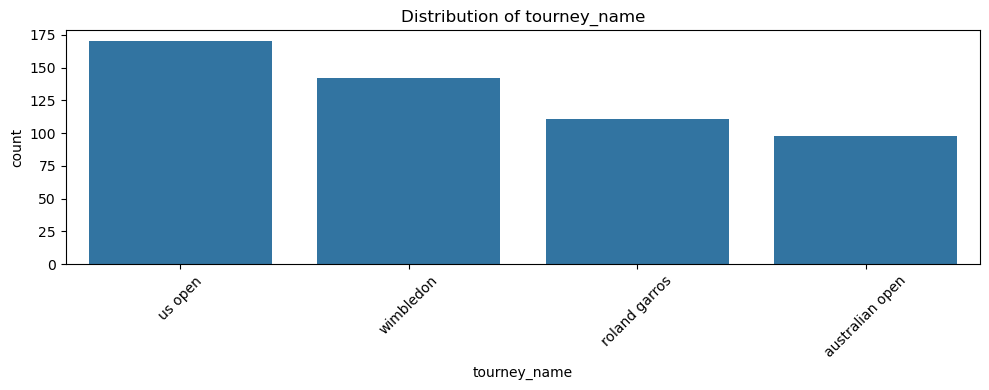

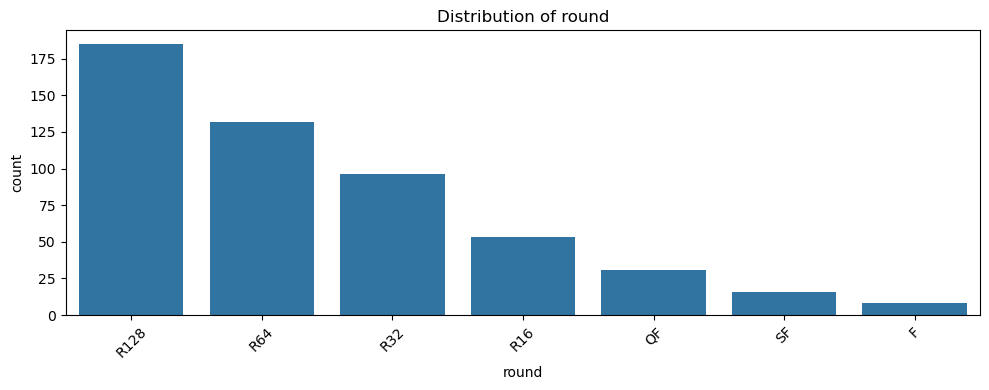

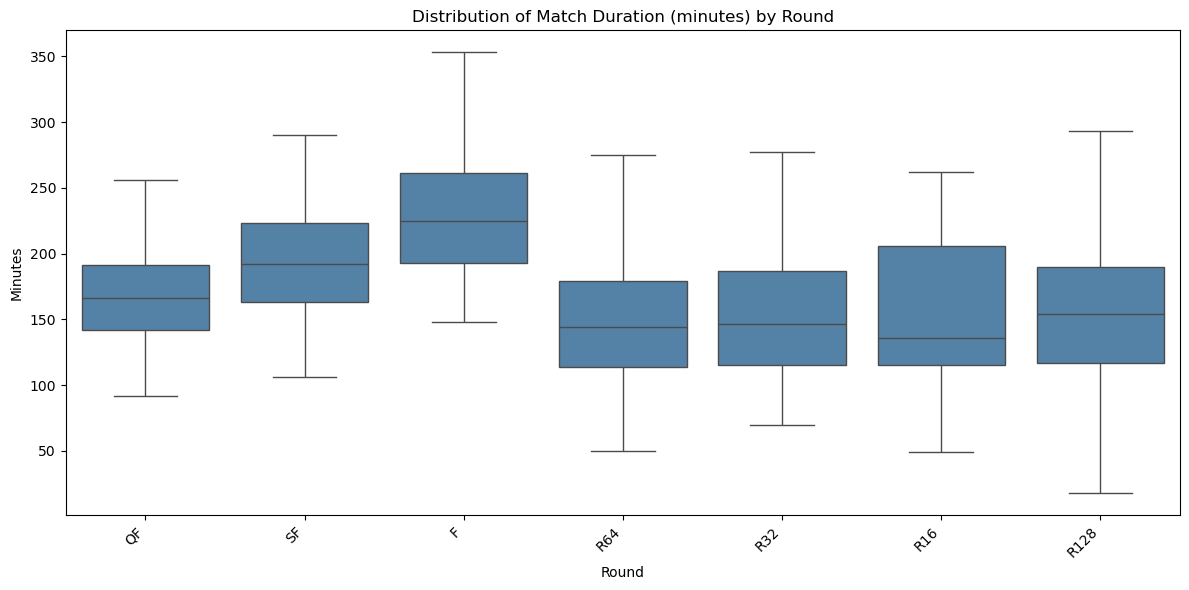

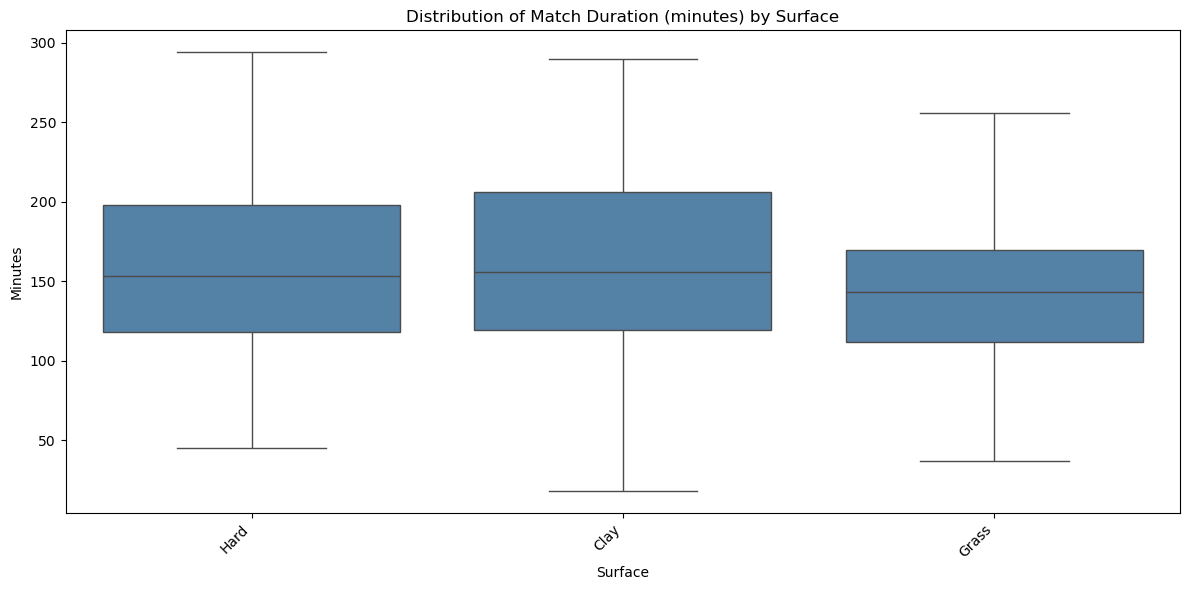

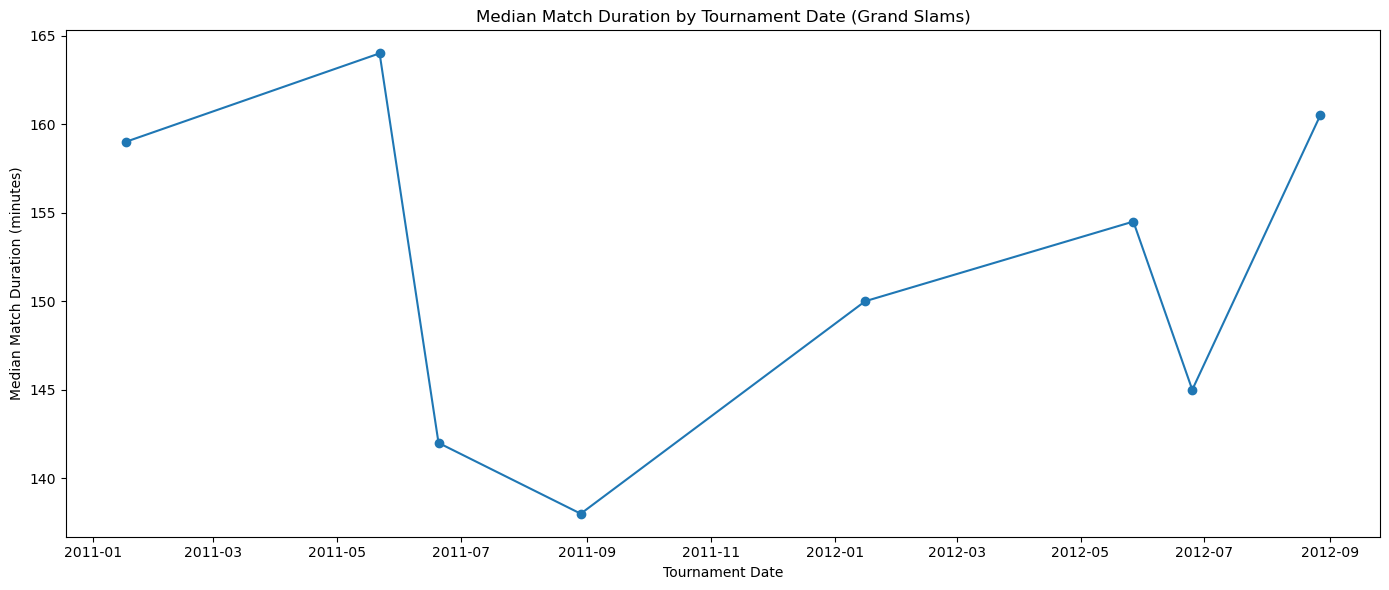

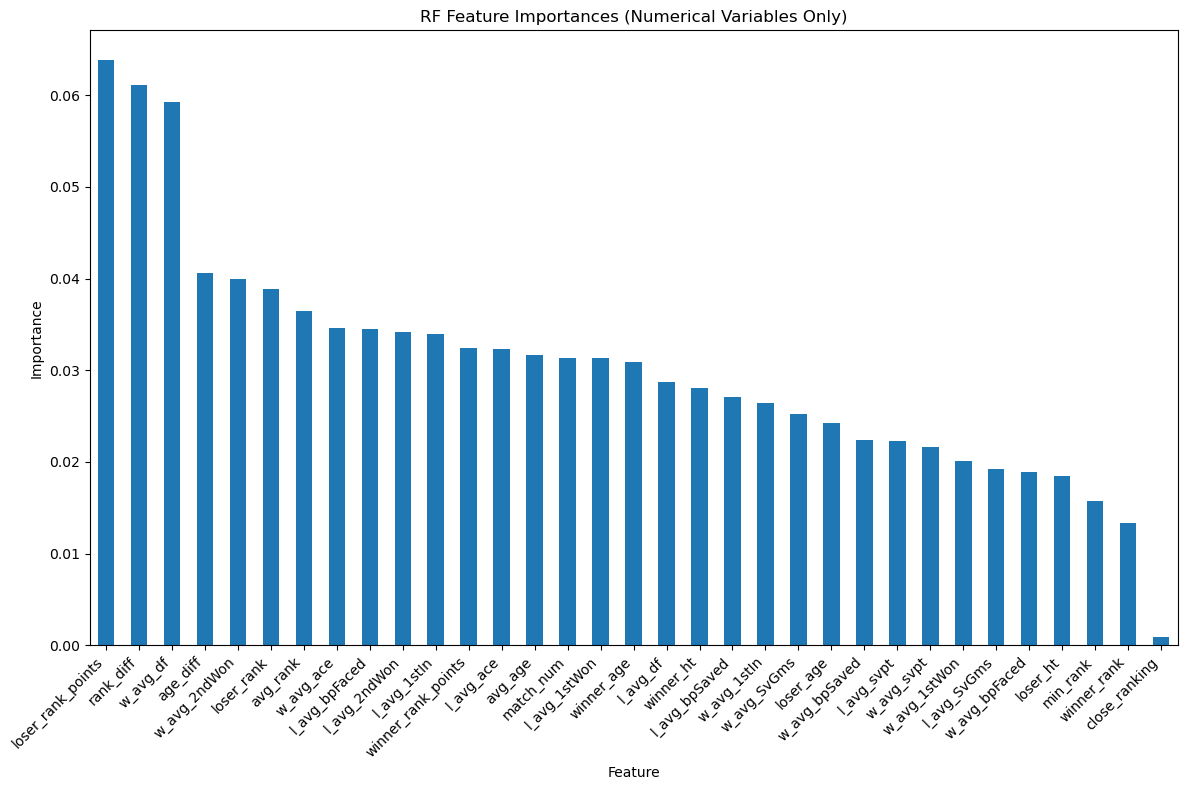


✅ All columns are numeric and ready for modeling.

📊 VIF Scores (Numerical Features Only):
               feature          VIF
13             avg_age          inf
2           winner_age          inf
4            loser_age          inf
5          winner_rank          inf
7           loser_rank          inf
9            rank_diff          inf
10            avg_rank          inf
11            min_rank          inf
0                const  3667.205523
17          w_avg_svpt   114.004755
26          l_avg_svpt   100.920802
28        l_avg_1stWon   100.074793
19        w_avg_1stWon    95.784856
32       l_avg_bpFaced    93.603041
23       w_avg_bpFaced    91.765019
31       l_avg_bpSaved    41.940526
22       w_avg_bpSaved    41.520854
18         w_avg_1stIn    36.699167
21         w_avg_SvGms    36.263816
20        w_avg_2ndWon    35.593315
29        l_avg_2ndWon    32.542665
27         l_avg_1stIn    31.465459
30         l_avg_SvGms    29.893228
24           l_avg_ace     3.584105
15      

/home/cord2108/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
from limpieza import main 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

file_path = "/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/atp_matches_till_2022.csv"
final_data = main(file_path, show_plots=True, year_start=2011,year_end=2012)
import os

# ruta de la carpeta donde quieres guardar el CSV
dir_path = "/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data"

# nombre del archivo CSV
filename = "best_of_five.csv"

# construye la ruta completa
output_path = os.path.join(dir_path, filename)

# escribe el DataFrame sin la columna de índice
final_data.to_csv(output_path, index=False)


In [2]:
best_of_five = final_data.copy()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols_5 = best_of_five.select_dtypes(include='number')

corr_matrix_5 = numeric_cols_5.corr()

correlations_with_minutes_5 = corr_matrix_5["minutes"].sort_values(key=abs, ascending=False)

print("\nTop correlations with 'minutes' (Best of 5):")
print(correlations_with_minutes_5)



Top correlations with 'minutes' (Best of 5):
minutes               1.000000
loser_rank_points     0.232489
surface_Grass        -0.149353
close_ranking         0.116792
w_avg_df              0.104191
age_diff             -0.097559
l_avg_ace             0.091682
winner_rank_points   -0.069595
surface_Hard          0.060091
loser_ht              0.057304
winner_ht             0.042406
l_avg_df             -0.018552
w_avg_ace             0.004958
Name: minutes, dtype: float64


# Distribucion general de minutos

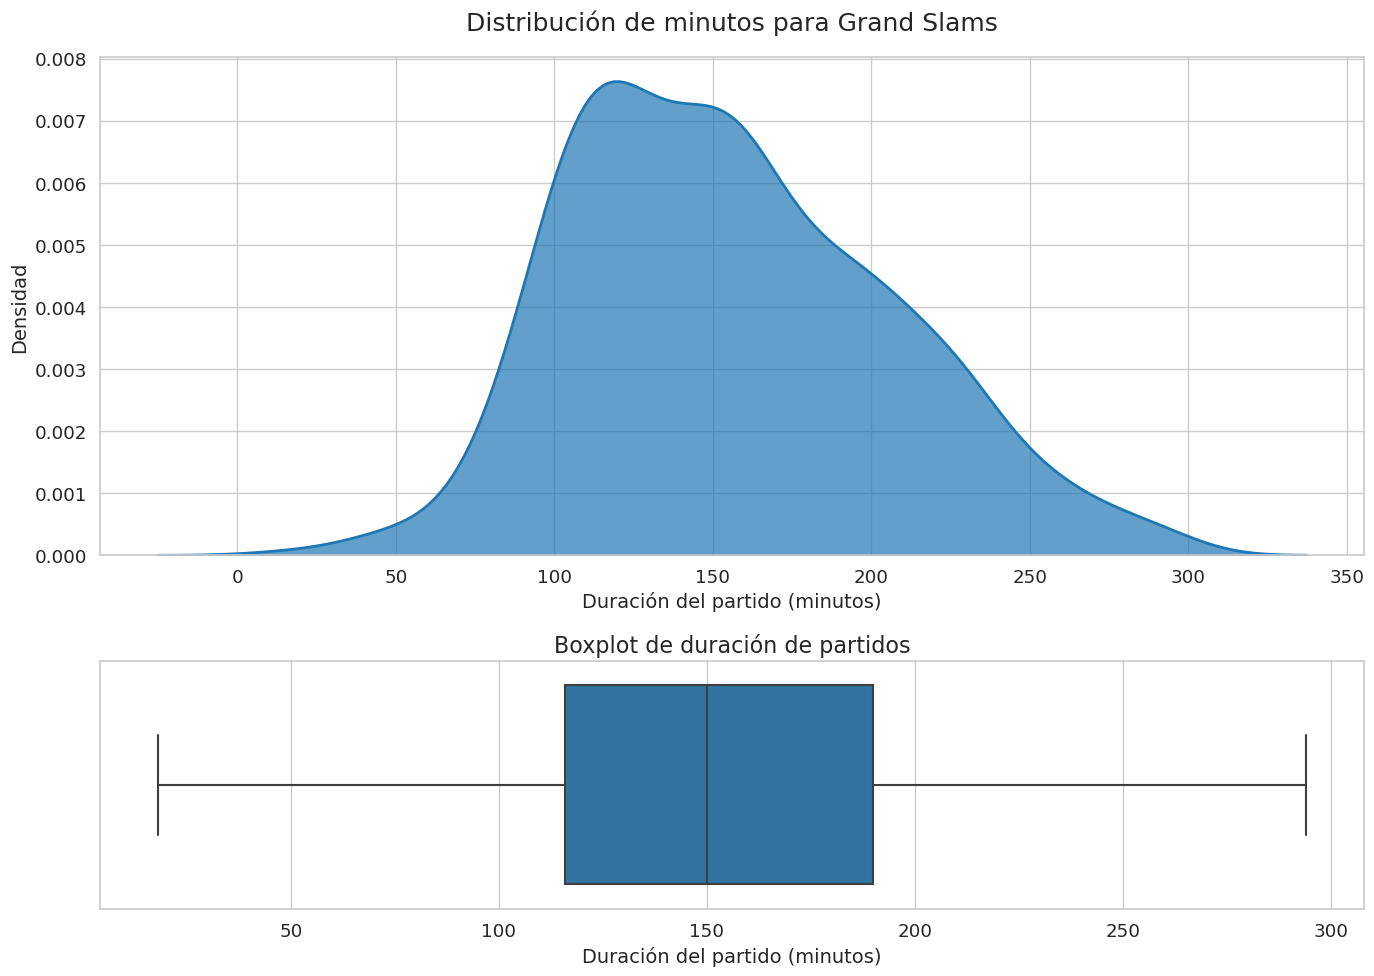

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# === KDE and Box Plot side-by-side ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# === KDE Plot ===
sns.kdeplot(
    data=best_of_five, 
    x="minutes", 
    fill=True, 
    color="#1f77b4", 
    linewidth=2, 
    alpha=0.7, 
    ax=axes[0]
)
axes[0].set_title("Distribución de minutos para Grand Slams", fontsize=18, pad=20)
axes[0].set_xlabel("Duración del partido (minutos)", fontsize=14)
axes[0].set_ylabel("Densidad", fontsize=14)

# === Box Plot ===
sns.boxplot(
    data=best_of_five, 
    x="minutes", 
    color="#1f77b4", 
    linewidth=1.5, 
    ax=axes[1]
)
axes[1].set_xlabel("Duración del partido (minutos)", fontsize=14)
axes[1].set_title("Boxplot de duración de partidos", fontsize=16)

plt.tight_layout()
plt.show()


# Modelo regresion lineal

## Fundamento teórico del modelo y los diagnósticos

### 1. Modelo lineal con interacciones

Partimos del **modelo lineal general**  
$$
\mathbf y = \mathbf X\,\boldsymbol\beta + \boldsymbol\varepsilon,
$$
donde  
- $\mathbf y\in\mathbb R^n$ es el vector de observaciones de la duración de los partidos.  
- $\mathbf X\in\mathbb R^{n\times p}$ es la **matriz de diseño**, que incluye  
  1. Una columna de unos para el intercepto,  
  2. Dummies de superficie (`Grass`, `Hard` versus la referencia `Clay`),  
  3. Variables numéricas base ($\mathbf X_{\text{base}}$),  
  4. Términos de interacción ($\mathbf X_{\text{base}}\times\text{dummies}$).  
- $\boldsymbol\beta\in\mathbb R^p$ contiene  
  - $\beta_0$: intercepto base (superficie de referencia),  
  - $\beta_d$: desplazamientos de intercepto por superficie,  
  - $\gamma_k$: pendientes base de las variables numéricas,  
  - $\delta_{k,d}$: ajustes de pendiente (interacción) para cada superficie.  
- $\boldsymbol\varepsilon$ son los residuos, asumiendo $\mathbb{E}[\varepsilon_i]=0$, $\operatorname{Var}(\varepsilon_i)=\sigma^2$ e independencia.

La estimación por **mínimos cuadrados ordinarios (OLS)** minimiza  
$$
\min_{\boldsymbol b}\,\|\mathbf y - \mathbf X\boldsymbol b\|^2
\quad\longrightarrow\quad
\widehat{\boldsymbol\beta} = (\mathbf X^\top\mathbf X)^{-1}\mathbf X^\top\mathbf y.
$$

### 2. Prevención de colinealidad: VIF

Para garantizar que $\mathbf X^\top\mathbf X$ sea numéricamente estable, calculamos el **Factor de Inflación de Varianza (VIF)** para cada predictor $j$:
$$
\mathrm{VIF}_j = \frac{1}{1 - R_j^2},
$$
donde $R_j^2$ es la $R^2$ al regredir la columna $j$ contra el resto de columnas de $\mathbf X$. Valores de VIF > 10 indican colinealidad excesiva y se descartan variables para evitar estimaciones inestables.

### 3. Diagnósticos de ajuste

Una vez ajustado el modelo, usamos los residuos y valores ajustados para comprobar los supuestos:

1. **Residuos vs Ajustados:**  
   Busca patrones sistemáticos. Un embudo o forma curva sugiere **heterocedasticidad**.

2. **Gráfico Q–Q de residuos:**  
   Compara cuantiles empíricos de residuos con cuantiles teóricos normales. Desviaciones en las colas indican **no normalidad**.

3. **Escala–Local** ($\sqrt{|e_i^*|}$ vs predichos):  
   Estima homocedasticidad en escala de residuos estandarizados; la línea LOWESS debe ser aproximadamente horizontal.

4. **Leverage vs Residuos estandarizados:**  
   - **Leverage** ($h_{ii}$) mide la influencia de la $i$-ésima fila en el ajuste  
   - Residuos estandarizados altos ± leverage alto pueden indicar puntos influyentes.

5. **Distancia de Cook:**  
   $$
   D_i = \frac{e_i^2}{p\,\hat\sigma^2}\,\frac{h_{ii}}{(1-h_{ii})^2},
   $$
   cuantifica el cambio en $\widehat{\boldsymbol\beta}$ al eliminar la observación $i$. Valores $D_i>4/n$ señalan observaciones influyentes.

6. **Histograma de residuos con curva normal:**  
   Muestra la distribución de residuos y comprueba asimetría o colas pesadas.

### 4. Interpretación y robustez

- La inclusión de **interacciones** permite que **cada superficie tenga su propia pendiente** para cada variable predictora, capturando efectos contextuales distintos (por ejemplo, cómo `age_diff` impacta diferente en césped versus arcilla).  
- Los diagnósticos confirman o refutan los supuestos de OLS; en presencia de violaciones severas (heterocedasticidad, no normalidad, outliers muy influyentes), podríamos:  
  - Aplicar transformaciones (log–link, Box–Cox).  
  - Usar **regresión ponderada** o modelos de **robustez** (e.g., Huber).  
  - Implementar alternativas **machine learning** más flexibles.

Con esta fundamentación, el bloque de código implementa un análisis exhaustivo que va más allá de la mera estimación de coeficientes, asegurando la validez estadística y la interpretabilidad del modelo.

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     6.338
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.64e-10
Time:                        18:45:43   Log-Likelihood:                -2732.0
No. Observations:                 519   AIC:                             5490.
Df Residuals:                     506   BIC:                             5545.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 32.4703     98

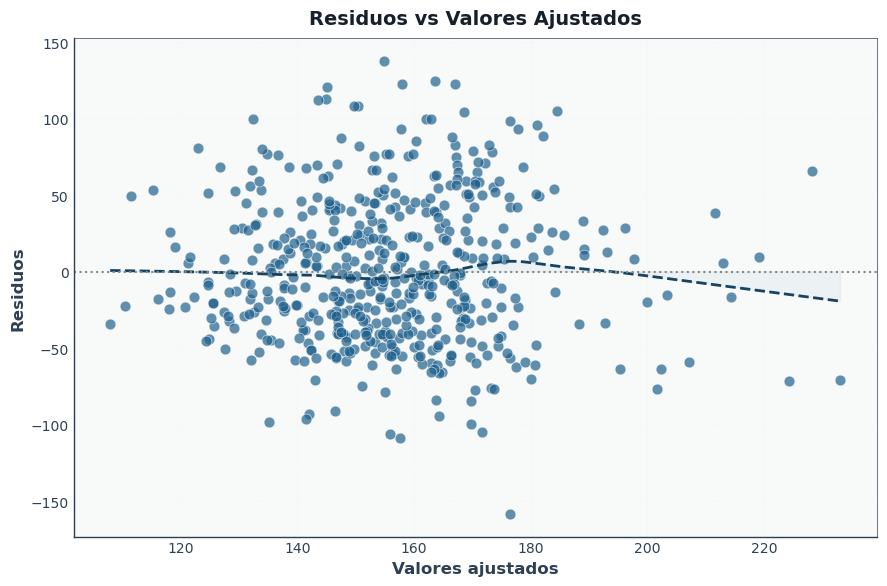

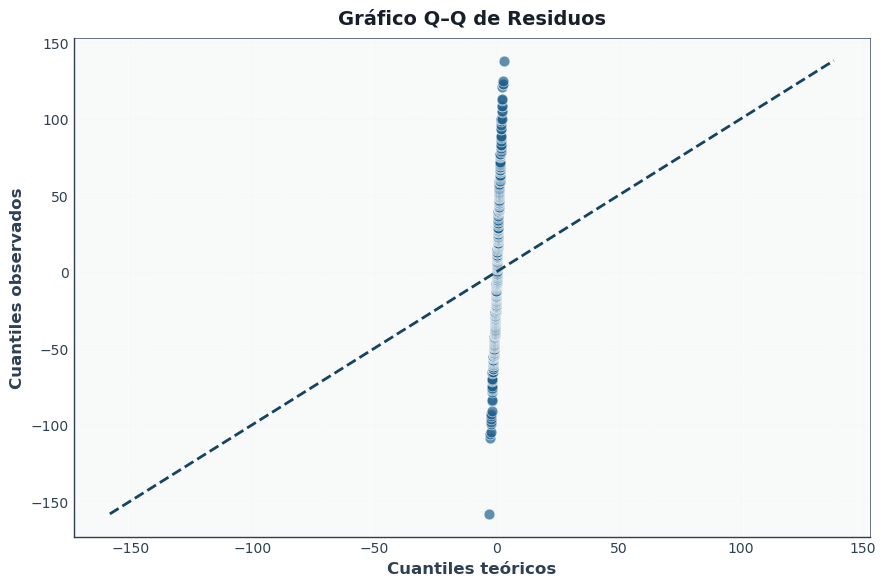

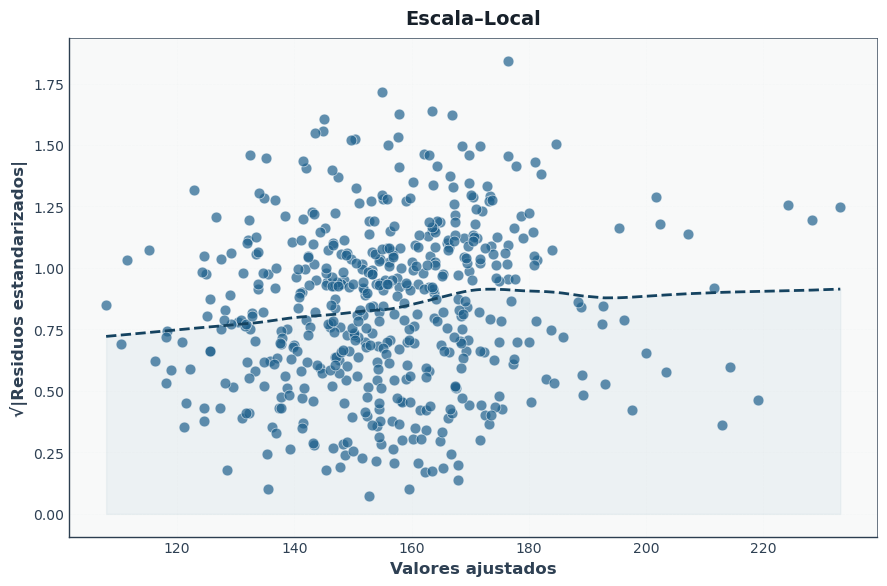

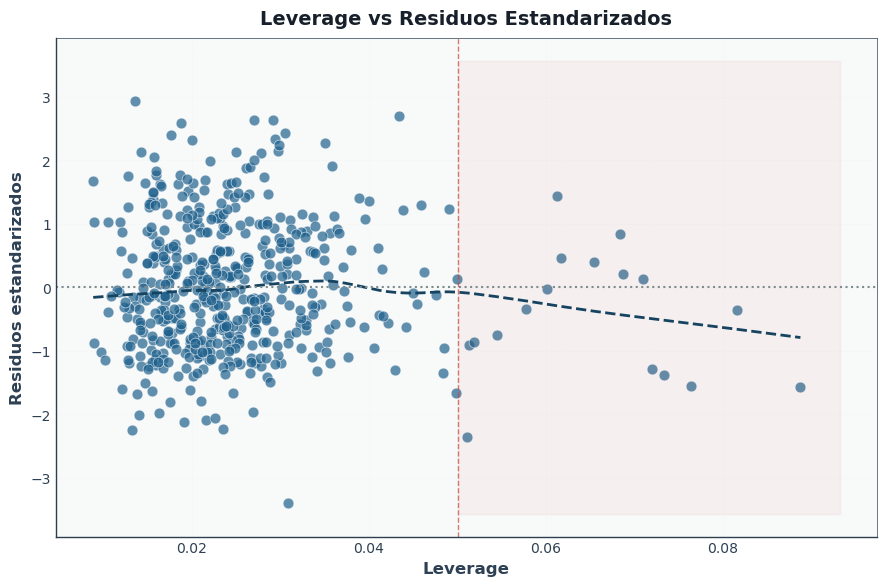

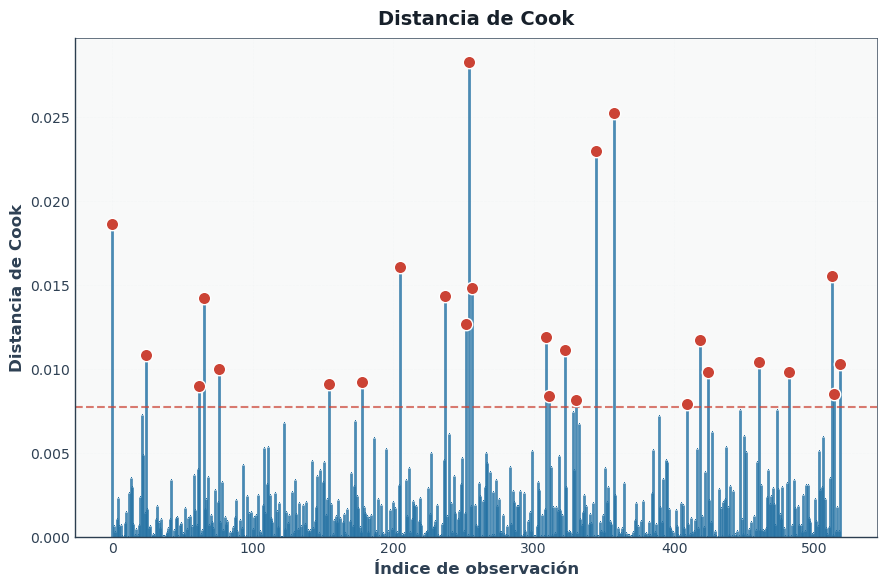

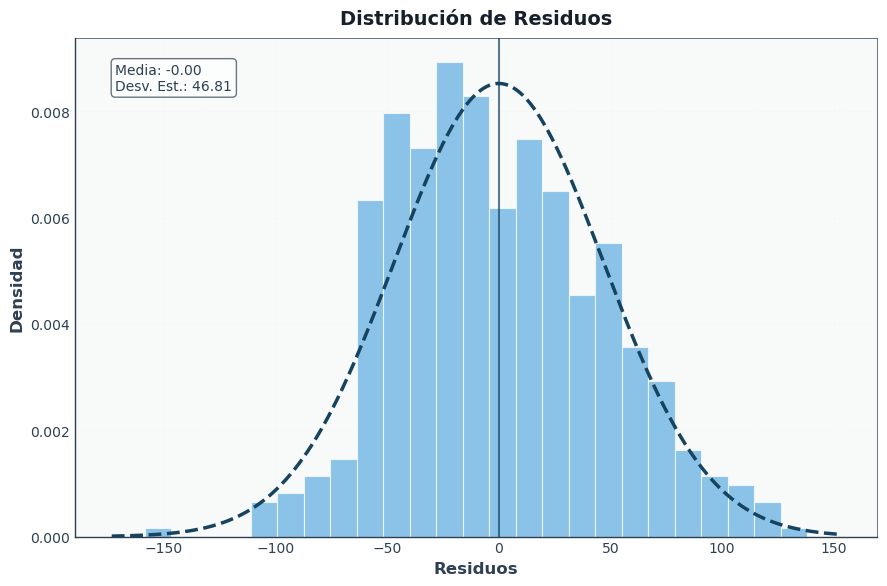

/tmp/ipykernel_9009/67488027.py:309: RuntimeWarning: divide by zero encountered in divide
  umbral_leverage = 2 * (p + 1) / n


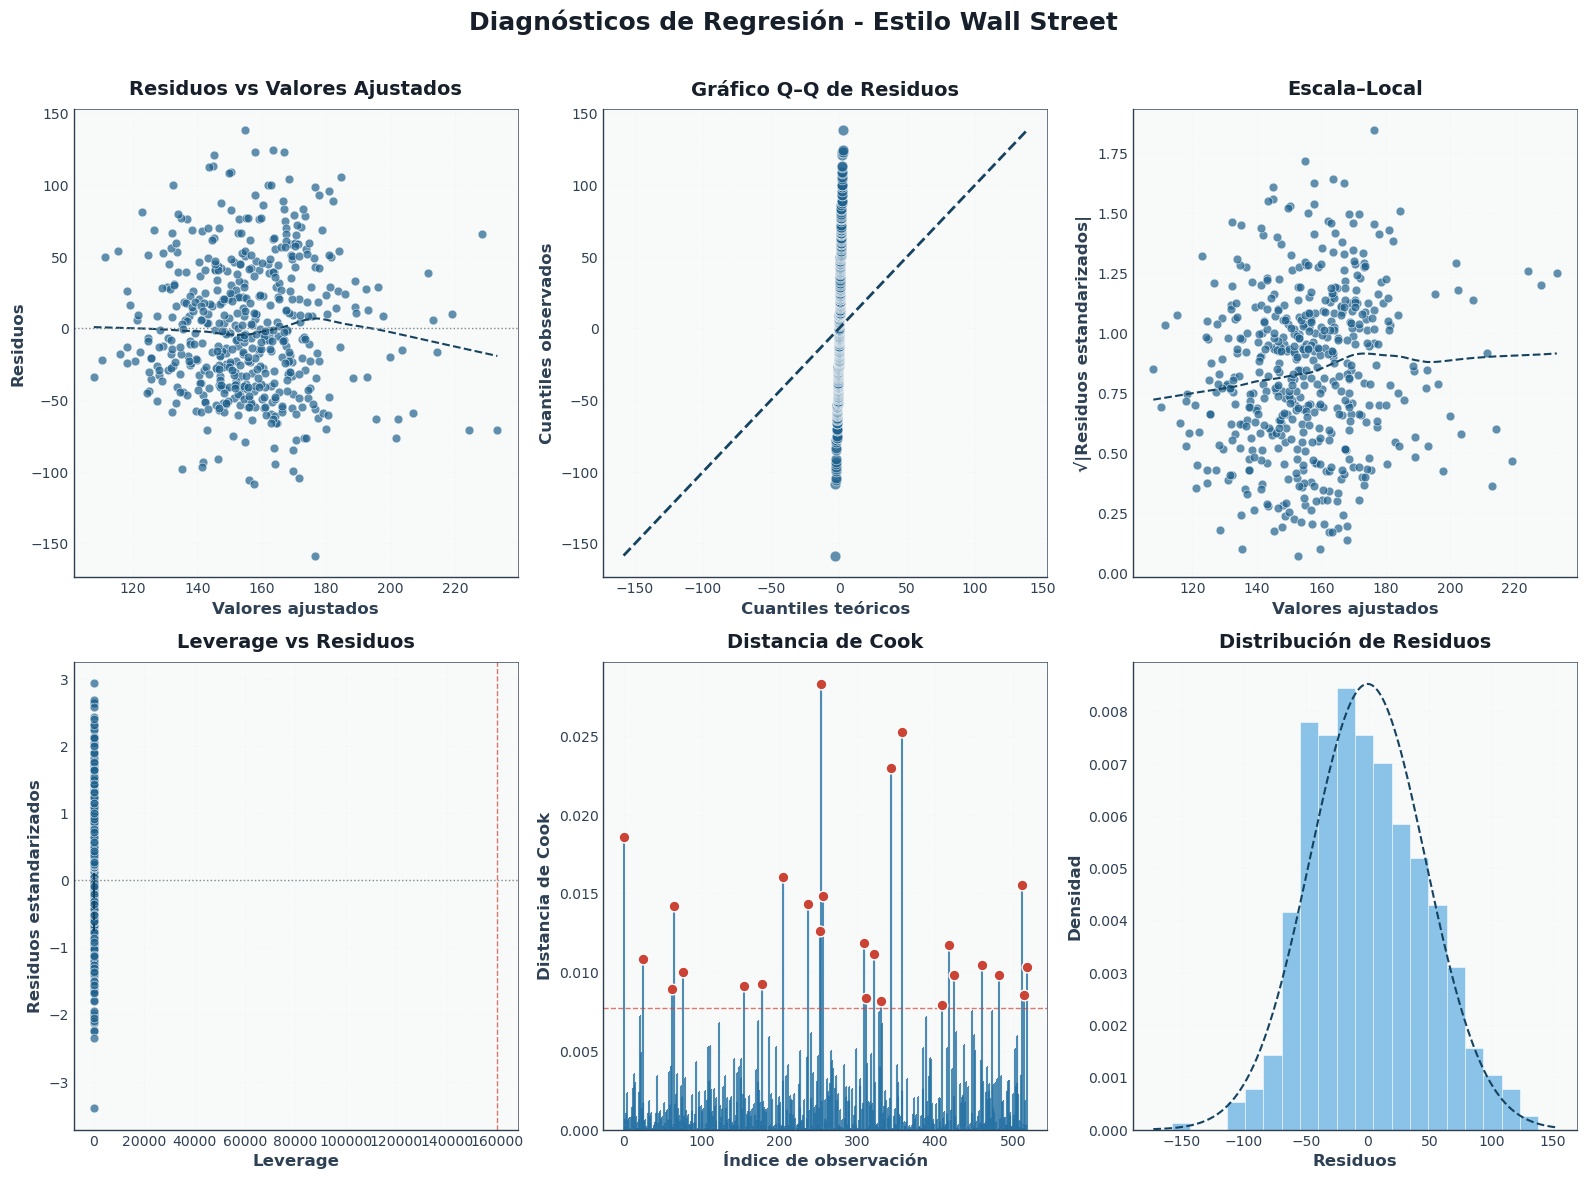

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy import stats
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# === Configuración de estilo "Wall Street" mejorado ===
plt.style.use('seaborn-v0_8-whitegrid')  # Base estilo seaborn como punto de partida

# Configuración de fuentes más profesionales - usando fuentes genéricas disponibles en todos los sistemas
plt.rcParams.update({
    'font.family': 'sans-serif',  # Cambiado de 'serif' a 'sans-serif' que está más disponible
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 100,
    'figure.figsize': (8, 5),
    'axes.facecolor': 'white',
    'axes.edgecolor': '#2E4053',
    'axes.labelcolor': '#2E4053',
    'axes.grid': True,
    'grid.color': '#ECF0F1',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'xtick.color': '#2E4053',
    'ytick.color': '#2E4053',
    'text.color': '#2E4053',
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Paleta de azules para estilo financiero/Wall Street
col = {
    'puntos': '#1F618D',       # Azul oscuro para puntos
    'puntos_alpha': 0.7,       # Transparencia
    'lowess': '#154360',       # Azul más oscuro para líneas de tendencia
    'hist': '#5DADE2',         # Azul medio para histogramas
    'stem': '#2471A3',         # Azul intenso para gráficos de tallo
    'linea_cero': '#7F8C8D',   # Gris para líneas de referencia
    'titulo': '#17202A',       # Casi negro para títulos
    'grid': '#ECF0F1',         # Gris muy claro para cuadrículas
    'borde': '#2C3E50',        # Azul oscuro para bordes
    'fondo_panel': '#F8F9F9'   # Gris muy claro para fondo de paneles
}

# Estilo común para todos los gráficos
def estilo_comun(ax, titulo):
    """Aplica estilo común a todos los gráficos"""
    ax.set_facecolor(col['fondo_panel'])
    ax.spines['bottom'].set_color(col['borde'])
    ax.spines['left'].set_color(col['borde'])
    ax.spines['top'].set_color(col['borde'])
    ax.spines['right'].set_color(col['borde'])
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    ax.grid(True, alpha=0.3)
    ax.set_title(titulo, fontweight='bold', color=col['titulo'], pad=10)

# === Paso 1: Preparar datos y ajustar modelo OLS ===
df = pd.read_csv("/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/best_of_five.csv")
y = df['minutes']
X = df.drop(columns=['minutes'])
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# === Paso 2: Resumen + Durbin–Watson ===
print(model.summary())
print(f"Durbin–Watson: {sms.durbin_watson(model.resid):.3f}")

# === Paso 3: Cálculos diagnósticos ===
fitted = model.fittedvalues
resid = model.resid
std_resid = model.get_influence().resid_studentized_internal
leverage = model.get_influence().hat_matrix_diag
influencia = OLSInfluence(model)
# Convertir a array de NumPy para evitar problemas de indexación
cooks = np.array(influencia.cooks_distance[0])

# === Paso 4: VIF ===
vif = pd.DataFrame({
    'Variable': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print("\nFactores de Inflación de Varianza:")
print(vif.round(2))

# === Paso 5: Gráficos diagnósticos mejorados ===

# 1. Residuos vs Ajustados
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
scatter = ax.scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], 
                    s=60, edgecolor='white', linewidth=0.5)
low = sm.nonparametric.lowess(resid, fitted)
ax.plot(low[:,0], low[:,1], color=col['lowess'], linestyle='--', linewidth=2)
ax.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1.5)
ax.set_xlabel("Valores ajustados", fontweight='bold')
ax.set_ylabel("Residuos", fontweight='bold')
estilo_comun(ax, "Residuos vs Valores Ajustados")

# Añadir efecto de sombreado para destacar
ax.fill_between(low[:,0], low[:,1], 0, where=low[:,1]>0, 
                interpolate=True, color=col['puntos'], alpha=0.05)
ax.fill_between(low[:,0], low[:,1], 0, where=low[:,1]<0, 
                interpolate=True, color=col['puntos'], alpha=0.05)

plt.tight_layout()
plt.show()

# 2. Q–Q Plot de residuos mejorado
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
# Uso una función personalizada en lugar de sm.qqplot para más control sobre el estilo
def qqplot_custom(data, ax):
    q_theoretical = np.linspace(0.001, 0.999, len(data))
    y = np.sort(data)
    x = stats.norm.ppf(q_theoretical, loc=0, scale=1)
    ax.scatter(x, y, alpha=col['puntos_alpha'], color=col['puntos'], 
              s=60, edgecolor='white', linewidth=0.5)
    
    # Línea de 45 grados
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    ax.plot([min_val, max_val], [min_val, max_val], color=col['lowess'], 
            linestyle='--', linewidth=2)
    
    return ax

qqplot_custom(resid, ax)
ax.set_xlabel("Cuantiles teóricos", fontweight='bold')
ax.set_ylabel("Cuantiles observados", fontweight='bold')
estilo_comun(ax, "Gráfico Q–Q de Residuos")
plt.tight_layout()
plt.show()

# 3. Escala–Local (√|residuo estandarizado|)
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
scatter = ax.scatter(fitted, np.sqrt(np.abs(std_resid)), 
                    alpha=col['puntos_alpha'], color=col['puntos'], 
                    s=60, edgecolor='white', linewidth=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
ax.plot(low2[:,0], low2[:,1], color=col['lowess'], linestyle='--', linewidth=2)
ax.set_xlabel("Valores ajustados", fontweight='bold')
ax.set_ylabel("√|Residuos estandarizados|", fontweight='bold')
estilo_comun(ax, "Escala–Local")

# Añadir efecto de sombreado para destacar tendencia
ax.fill_between(low2[:,0], low2[:,1], 0, 
                interpolate=True, color=col['puntos'], alpha=0.05)

plt.tight_layout()
plt.show()

# 4. Leverage vs Residuos estandarizados
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
scatter = ax.scatter(leverage, std_resid, 
                    alpha=col['puntos_alpha'], color=col['puntos'], 
                    s=60, edgecolor='white', linewidth=0.5)
low3 = sm.nonparametric.lowess(std_resid, leverage)
ax.plot(low3[:,0], low3[:,1], color=col['lowess'], linestyle='--', linewidth=2)
ax.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1.5)

# Añadir líneas de referencia para leverage alto
# Calcular un umbral de leverage (común es 2*(p+1)/n donde p es número de predictores y n es tamaño de muestra)
p = len(X.columns)
n = len(X)
umbral_leverage = 2 * (p + 1) / n

# Asegurarse de que umbral_leverage es un escalar
if isinstance(umbral_leverage, (list, np.ndarray)):
    umbral_leverage = float(umbral_leverage[0])

# Añadir la línea vertical para el umbral
ax.axvline(umbral_leverage, color='#CB4335', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel("Leverage", fontweight='bold')
ax.set_ylabel("Residuos estandarizados", fontweight='bold')
estilo_comun(ax, "Leverage vs Residuos Estandarizados")

# Añadir sombreado para destacar observaciones potencialmente influyentes
ax.fill_between([umbral_leverage, max(leverage)*1.05], 
                [-max(abs(std_resid))*1.05, -max(abs(std_resid))*1.05], 
                [max(abs(std_resid))*1.05, max(abs(std_resid))*1.05], 
                color='#CB4335', alpha=0.05)

plt.tight_layout()
plt.show()

# 5. Distancia de Cook con diseño mejorado
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

# Crear una base sombreada para el gráfico
ax.bar(np.arange(len(cooks)), cooks, color=col['hist'], alpha=0.3, width=0.8)

# Líneas de tallo para destacar cada punto
markerline, stemlines, baseline = ax.stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.setp(stemlines, 'color', col['stem'], 'linewidth', 2, 'alpha', 0.8)
plt.setp(markerline, 'color', col['stem'], 'markersize', 6)

# Añadir línea de umbral para puntos influyentes (común es 4/n)
umbral_cook = 4/len(cooks)
ax.axhline(umbral_cook, color='#CB4335', linestyle='--', linewidth=1.5, alpha=0.7)

# Identificar puntos influyentes - corregido para trabajar con array NumPy
puntos_influyentes = np.where(cooks > umbral_cook)[0]
if len(puntos_influyentes) > 0:
    # Ahora podemos indexar directamente el array NumPy
    ax.scatter(puntos_influyentes, cooks[puntos_influyentes], 
               color='#CB4335', s=80, zorder=3, edgecolor='white')

ax.set_xlabel("Índice de observación", fontweight='bold')
ax.set_ylabel("Distancia de Cook", fontweight='bold')
estilo_comun(ax, "Distancia de Cook")
plt.tight_layout()
plt.show()

# 6. Histograma de residuos con curva normal mejorado
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

# Histograma con más estilo
n, bins, patches = ax.hist(resid, bins=25, density=True, alpha=0.7, color=col['hist'], 
                           edgecolor='white', linewidth=0.8)

# Mejorar la curva normal
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
ax.plot(x, y, linestyle='--', color=col['lowess'], linewidth=2.5)

# Añadir línea vertical para la media
ax.axvline(resid.mean(), color=col['lowess'], linestyle='-', linewidth=1.5, alpha=0.7)

ax.set_xlabel("Residuos", fontweight='bold')
ax.set_ylabel("Densidad", fontweight='bold')
estilo_comun(ax, "Distribución de Residuos")

# Añadir estadísticas en el gráfico
textstr = f'Media: {resid.mean():.2f}\nDesv. Est.: {resid.std():.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor=col['borde'])
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# === BONUS: Gráfico combinado en panel único ===
# Crear un panel único con todos los gráficos de diagnóstico para una presentación profesional
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 3, figure=plt.gcf())

# 1. Residuos vs Ajustados
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], 
           s=40, edgecolor='white', linewidth=0.5)
low = sm.nonparametric.lowess(resid, fitted)
ax1.plot(low[:,0], low[:,1], color=col['lowess'], linestyle='--', linewidth=1.5)
ax1.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1)
ax1.set_xlabel("Valores ajustados", fontweight='bold')
ax1.set_ylabel("Residuos", fontweight='bold')
estilo_comun(ax1, "Residuos vs Valores Ajustados")

# 2. Q–Q Plot de residuos
ax2 = plt.subplot(gs[0, 1])
qqplot_custom(resid, ax2)
ax2.set_xlabel("Cuantiles teóricos", fontweight='bold')
ax2.set_ylabel("Cuantiles observados", fontweight='bold')
estilo_comun(ax2, "Gráfico Q–Q de Residuos")

# 3. Escala–Local
ax3 = plt.subplot(gs[0, 2])
ax3.scatter(fitted, np.sqrt(np.abs(std_resid)), 
           alpha=col['puntos_alpha'], color=col['puntos'], 
           s=40, edgecolor='white', linewidth=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
ax3.plot(low2[:,0], low2[:,1], color=col['lowess'], linestyle='--', linewidth=1.5)
ax3.set_xlabel("Valores ajustados", fontweight='bold')
ax3.set_ylabel("√|Residuos estandarizados|", fontweight='bold')
estilo_comun(ax3, "Escala–Local")

# 4. Leverage vs Residuos estandarizados
ax4 = plt.subplot(gs[1, 0])
ax4.scatter(leverage, std_resid, 
           alpha=col['puntos_alpha'], color=col['puntos'], 
           s=40, edgecolor='white', linewidth=0.5)
low3 = sm.nonparametric.lowess(std_resid, leverage)
ax4.plot(low3[:,0], low3[:,1], color=col['lowess'], linestyle='--', linewidth=1.5)
ax4.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1)

# Calcular umbral de leverage y asegurarse de que sea un escalar
umbral_leverage = 2 * (p + 1) / n
if isinstance(umbral_leverage, (list, np.ndarray)):
    umbral_leverage = float(umbral_leverage[0])

# Añadir la línea vertical para el umbral
ax4.axvline(umbral_leverage, color='#CB4335', linestyle='--', linewidth=1, alpha=0.7)

ax4.set_xlabel("Leverage", fontweight='bold')
ax4.set_ylabel("Residuos estandarizados", fontweight='bold')
estilo_comun(ax4, "Leverage vs Residuos")

# 5. Distancia de Cook
ax5 = plt.subplot(gs[1, 1])
ax5.bar(np.arange(len(cooks)), cooks, color=col['hist'], alpha=0.3, width=0.8)
markerline, stemlines, baseline = ax5.stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.setp(stemlines, 'color', col['stem'], 'linewidth', 1.5, 'alpha', 0.8)
umbral_cook = 4/len(cooks)
ax5.axhline(umbral_cook, color='#CB4335', linestyle='--', linewidth=1, alpha=0.7)

# Identificar puntos influyentes - corregido para trabajar con array NumPy
puntos_influyentes = np.where(cooks > umbral_cook)[0]
if len(puntos_influyentes) > 0:
    # Ahora podemos indexar directamente el array NumPy
    ax5.scatter(puntos_influyentes, cooks[puntos_influyentes], 
               color='#CB4335', s=60, zorder=3, edgecolor='white')

ax5.set_xlabel("Índice de observación", fontweight='bold')
ax5.set_ylabel("Distancia de Cook", fontweight='bold')
estilo_comun(ax5, "Distancia de Cook")

# 6. Histograma de residuos
ax6 = plt.subplot(gs[1, 2])
n, bins, patches = ax6.hist(resid, bins=20, density=True, alpha=0.7, color=col['hist'], 
                           edgecolor='white', linewidth=0.5)
xmin, xmax = ax6.get_xlim()
x = np.linspace(xmin, xmax, 500)
y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
ax6.plot(x, y, linestyle='--', color=col['lowess'], linewidth=1.5)
ax6.set_xlabel("Residuos", fontweight='bold')
ax6.set_ylabel("Densidad", fontweight='bold')
estilo_comun(ax6, "Distribución de Residuos")

plt.suptitle("Diagnósticos de Regresión - Estilo Wall Street", 
             fontsize=18, fontweight='bold', color=col['titulo'], y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Prueba anova para checar la diferencia de medias entre los diferentes tipos de superficie

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, f
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 1) Reconstruir la variable categórica 'surface_cat'
df = pd.read_csv("/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/best_of_five.csv")
df['surface_cat'] = np.select(
    [df['surface_Grass'] == 1, df['surface_Hard'] == 1],
    ['Grass', 'Hard'],
    default='Clay'
)

# 2) ANOVA con statsmodels
modelo   = ols('minutes ~ C(surface_cat)', data=df).fit()
tabla_anova = sm.stats.anova_lm(modelo, typ=1)

# 3) Extraer valores clave
ssb   = tabla_anova.loc['C(surface_cat)', 'sum_sq']
dfb   = int(tabla_anova.loc['C(surface_cat)', 'df'])
ssw   = tabla_anova.loc['Residual',            'sum_sq']
dfw   = int(tabla_anova.loc['Residual',            'df'])
F_val = (ssb/dfb) / (ssw/dfw)
p_val = tabla_anova.loc['C(surface_cat)', 'PR(>F)']

# 4) Calcular valor crítico F para α=0.05
alpha  = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)

# 5) Calcular medias de duración por superficie
medias = df.groupby('surface_cat')['minutes'].mean()

# 6) Interpretación automática
print("=== Tabla ANOVA ===")
print(tabla_anova)
print(f"\nEstadístico F = {F_val:.3f}, p-valor = {p_val:.3e}")
print(f"Grados de libertad: entre = {dfb}, dentro = {dfw}")
print(f"Valor crítico F (α={alpha}): {F_crit:.3f}\n")

if F_val > F_crit:
    print("→ F > F crítico: rechazamos H₀ (las medias difieren significativamente).")
else:
    print("→ F ≤ F crítico: no rechazamos H₀ (no hay evidencia de diferencias).")

if p_val < alpha:
    print("→ p-valor < α: confirma el rechazo de H₀.")
else:
    print("→ p-valor ≥ α: confirma que no hay evidencia para rechazar H₀.")

print("\n=== Medias de duración por superficie ===")
print(medias)


=== Tabla ANOVA ===
                   df        sum_sq       mean_sq         F    PR(>F)
C(surface_cat)    2.0  3.158844e+04  15794.220044  6.397216  0.001801
Residual        516.0  1.273963e+06   2468.920672       NaN       NaN

Estadístico F = 6.397, p-valor = 1.801e-03
Grados de libertad: entre = 2, dentro = 516
Valor crítico F (α=0.05): 3.013

→ F > F crítico: rechazamos H₀ (las medias difieren significativamente).
→ p-valor < α: confirma el rechazo de H₀.

=== Medias de duración por superficie ===
surface_cat
Clay     164.234234
Grass    143.432624
Hard     158.625468
Name: minutes, dtype: float64


# Regresion lineal con matriz diseño consdierando pendientes por categoría


## Definición matemática del modelo con matriz de diseño e interacciones

Sea $n$ el número de partidos y definamos:

- $\mathbf y = (y_1,\dots,y_n)^\top\in\mathbb{R}^n$ el vector de observaciones de la duración (`minutes`).
- $\mathbf X_{\text{base}}\in\mathbb{R}^{n\times K}$ la matriz de variables numéricas originales (por ejemplo, `age_diff`, `l_avg_ace`, …).
- $\mathbf Z\in\{0,1\}^{n\times D}$ la matriz de dummies para la variable categórica `surface_cat` con $D$ categorías (dejando una categoría como referencia).
- $\mathbf X_{\text{int}}\in\mathbb{R}^{n\times (K\cdot D)}$ la matriz de interacciones, donde cada columna es el producto elemento a elemento:
  $$
    \bigl[\mathbf X_{\text{int}}\bigr]_{i,(k,d)} = Z_{i,d}\;\bigl(\mathbf X_{\text{base}}\bigr)_{i,k}
    \quad\text{para }i=1,\dots,n,\;k=1,\dots,K,\;d=1,\dots,D.
  $$

Formamos la **matriz de diseño** completa
$$
\mathbf X = \bigl[\,\mathbf 1\;\bigm|\;\mathbf Z\;\bigm|\;\mathbf X_{\text{base}}\;\bigm|\;\mathbf X_{\text{int}}\,\bigr]
\;\in\mathbb{R}^{n\times p},
\quad
p = 1 + D + K + K\,D\,.
$$

El **modelo lineal** con interacciones se escribe como
$$
\mathbf y = \mathbf X\,\boldsymbol\beta + \boldsymbol\varepsilon,
$$
lo que en forma de ecuaciones individuales es:
$$
y_i
= \beta_0
+ \sum_{d=1}^D \beta_d\,Z_{i,d}
+ \sum_{k=1}^K \gamma_k\,X_{i,k}^{\text{base}}
+ \sum_{d=1}^D\sum_{k=1}^K \delta_{k,d}\,Z_{i,d}\,X_{i,k}^{\text{base}}
+ \varepsilon_i,
\quad i=1,\dots,n.
$$

Aquí:
- $\beta_0$ es el intercepto (valor medio cuando todas las dummies e interacciones valen 0).
- $\beta_d$ son los efectos de las dummies de superficie.
- $\gamma_k$ son las pendientes "base" de cada variable numérica.
- $\delta_{k,d}$ ajustan la pendiente de la variable $k$ en la categoría $d$.

La **estimación por mínimos cuadrados ordinarios** se obtiene resolviendo
$$
\widehat{\boldsymbol\beta}
= \arg\min_{\boldsymbol b\in\mathbb R^p}\|\mathbf y - \mathbf X\boldsymbol b\|^2
= (\mathbf X^\top\mathbf X)^{-1}\mathbf X^\top\mathbf y,
$$
y las residuales $\widehat{\boldsymbol\varepsilon} = \mathbf y - \mathbf X\widehat{\boldsymbol\beta}$ se usan para los diagnósticos de ajuste.

Tipos en X_const:
 const                       float64
Grass                          bool
Hard                           bool
age_diff                    float64
close_ranking                 int64
l_avg_ace                   float64
l_avg_df                    float64
loser_ht                    float64
loser_rank_points           float64
w_avg_ace                   float64
w_avg_df                    float64
winner_ht                   float64
winner_rank_points          float64
age_diff:Grass              float64
age_diff:Hard               float64
close_ranking:Grass           int64
close_ranking:Hard            int64
l_avg_ace:Grass             float64
l_avg_ace:Hard              float64
l_avg_df:Grass              float64
l_avg_df:Hard               float64
loser_ht:Grass              float64
loser_ht:Hard               float64
loser_rank_points:Grass     float64
loser_rank_points:Hard      float64
w_avg_ace:Grass             float64
w_avg_ace:Hard              float64
w_avg_df:

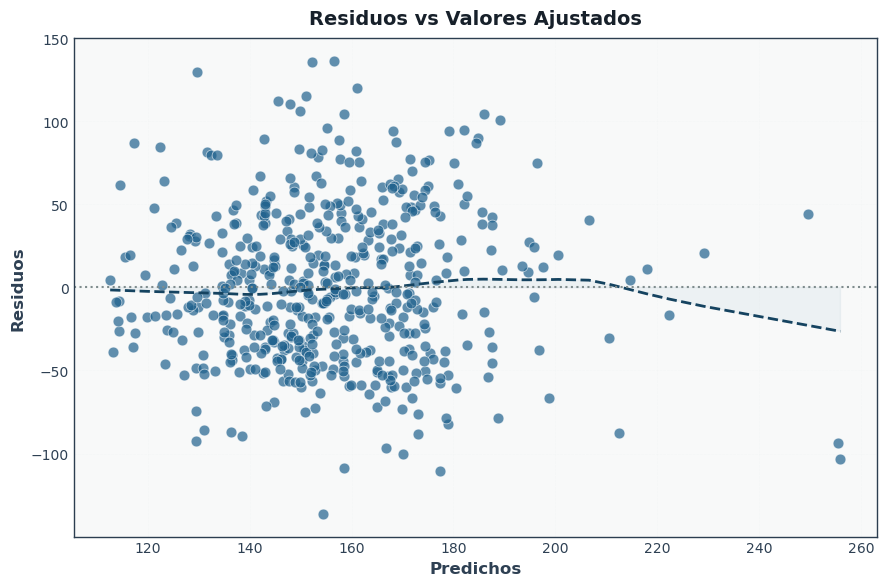

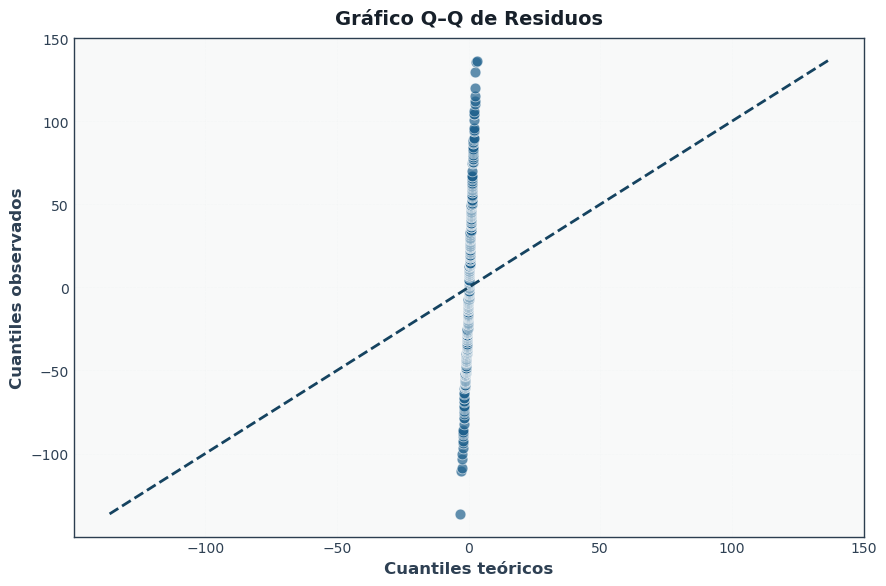

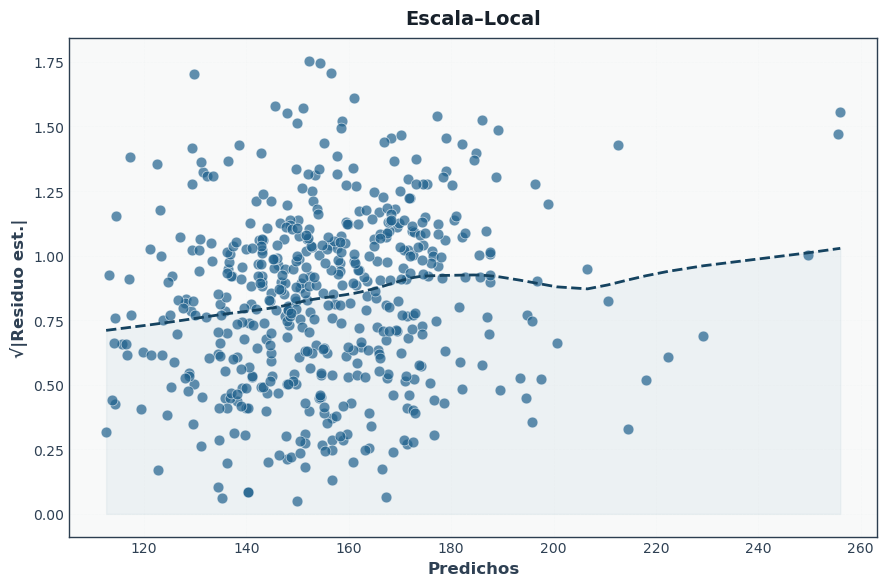

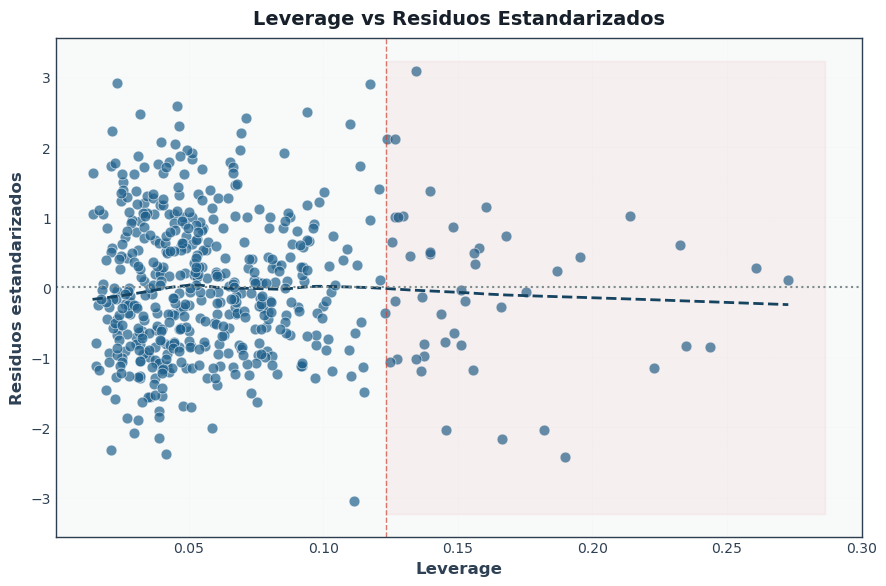

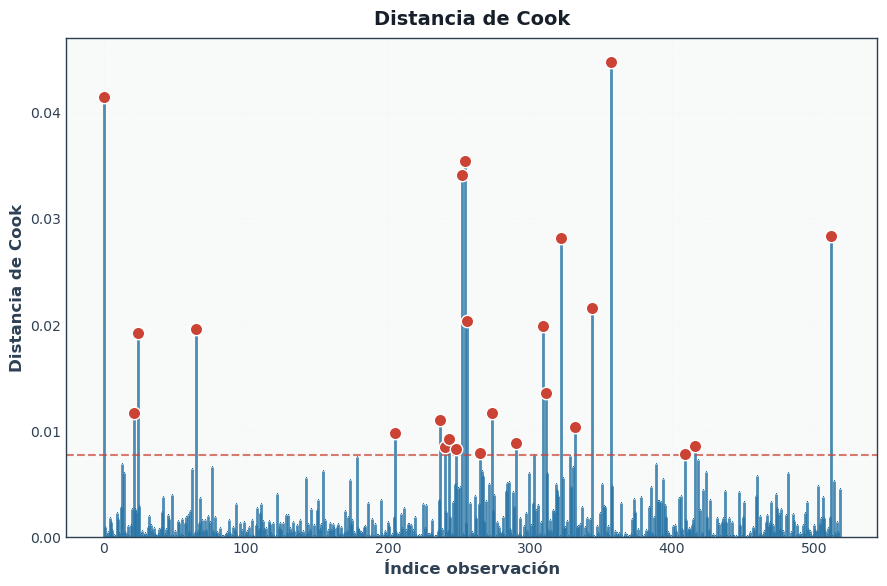

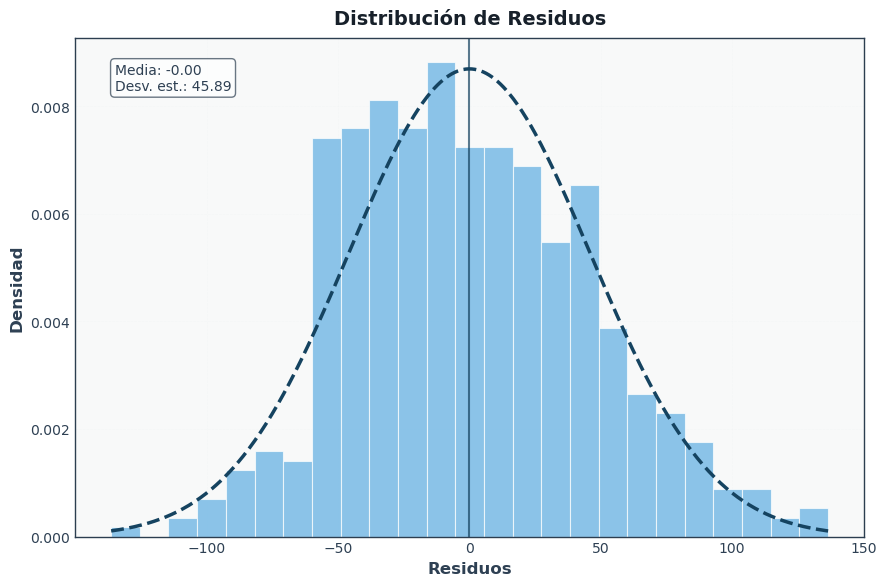

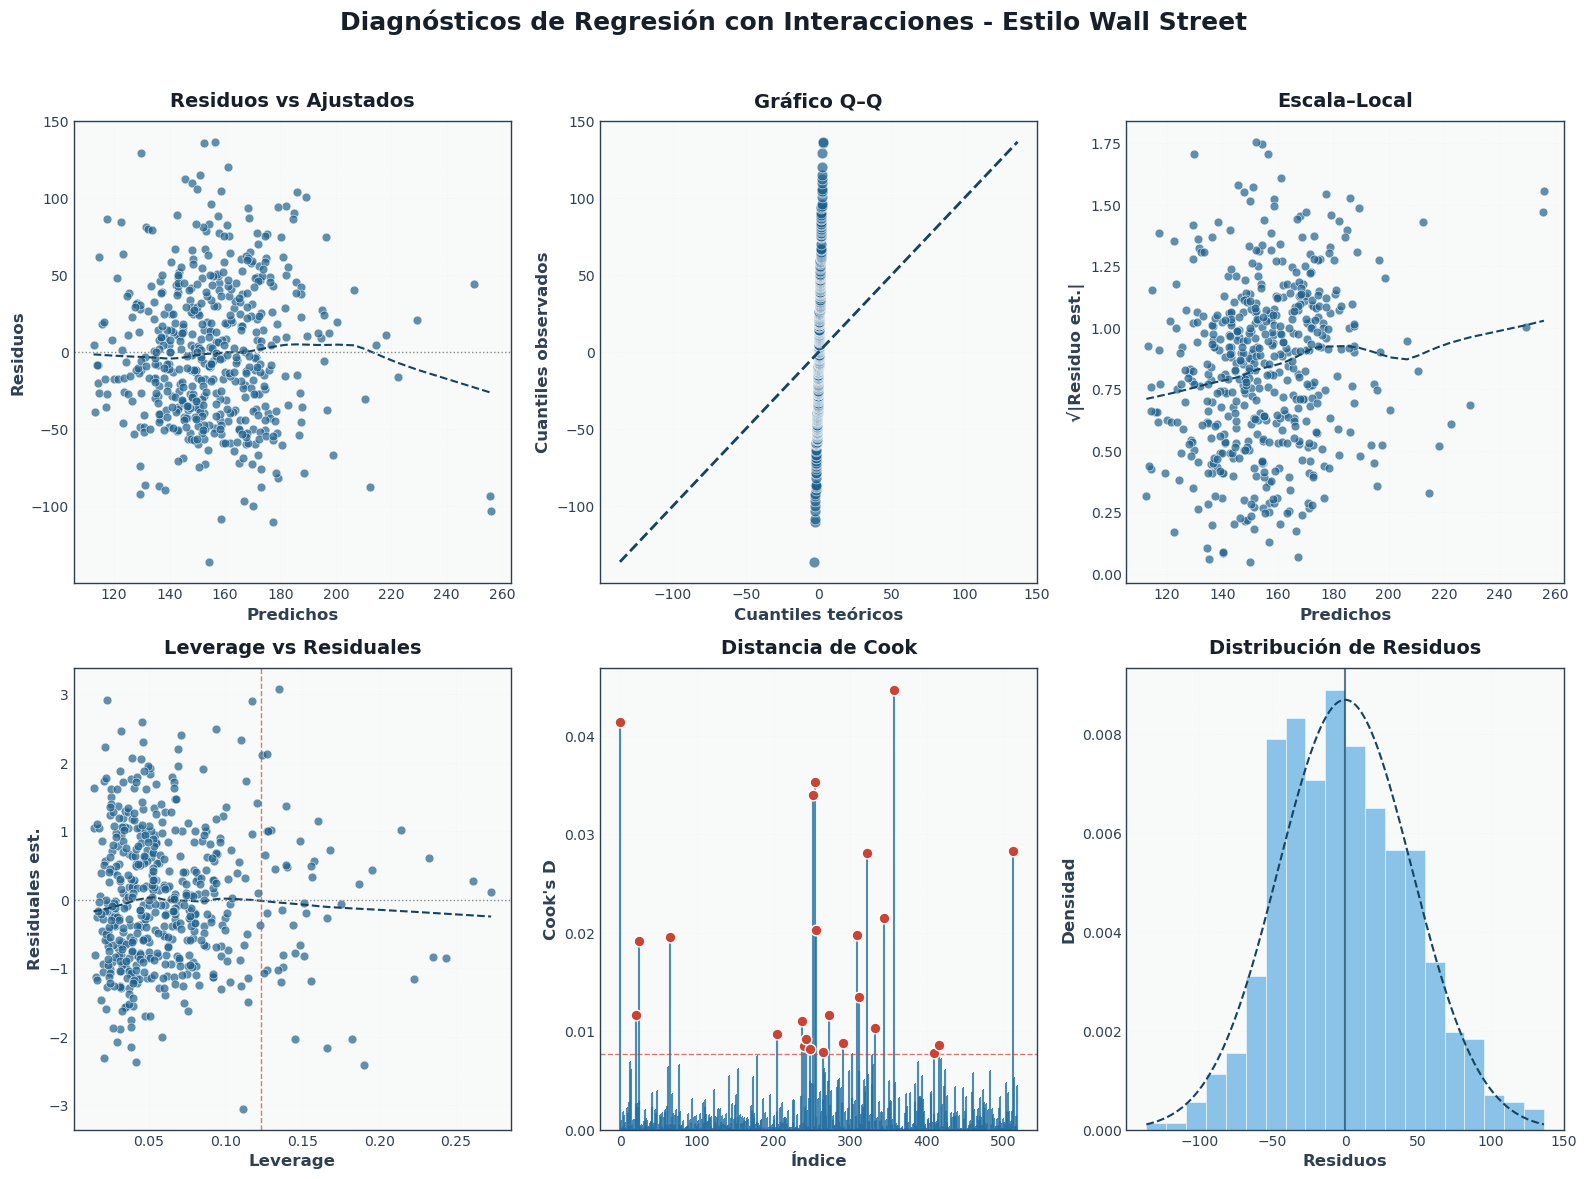

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy import stats
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# === Configuración de estilo "Wall Street" mejorado ===
plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 100,
    'figure.figsize': (8, 5),
    'axes.facecolor': 'white',
    'axes.edgecolor': '#2E4053',
    'axes.labelcolor': '#2E4053',
    'axes.grid': True,
    'grid.color': '#ECF0F1',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'xtick.color': '#2E4053',
    'ytick.color': '#2E4053',
    'text.color': '#2E4053',
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

col = {
    'puntos': '#1F618D',
    'puntos_alpha': 0.7,
    'lowess': '#154360',
    'hist': '#5DADE2',
    'stem': '#2471A3',
    'linea_cero': '#7F8C8D',
    'titulo': '#17202A',
    'grid': '#ECF0F1',
    'borde': '#2C3E50',
    'fondo_panel': '#F8F9F9'
}

def estilo_comun(ax, titulo):
    ax.set_facecolor(col['fondo_panel'])
    for spine in ax.spines.values():
        spine.set_color(col['borde'])
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    ax.grid(True, alpha=0.3)
    ax.set_title(titulo, fontweight='bold', color=col['titulo'], pad=10)

def qqplot_custom(data, ax):
    q = np.linspace(0.001, 0.999, len(data))
    y = np.sort(data)
    x = stats.norm.ppf(q)
    ax.scatter(x, y, alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
    mn, mx = min(x.min(), y.min()), max(x.max(), y.max())
    ax.plot([mn, mx], [mn, mx], linestyle='--', color=col['lowess'], lw=2)
    return ax

# === Paso 1: Preparar datos e incorporar interacciones ===
df = pd.read_csv("/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/best_of_five.csv")
y = df['minutes']

# Reconstruir categoría surface
df['surface_cat'] = np.select(
    [df['surface_Grass']==1, df['surface_Hard']==1],
    ['Grass','Hard'],
    default='Clay'
)

# Variables numéricas base
X_base = df[['age_diff', 'close_ranking', 'l_avg_ace', 'l_avg_df',
             'loser_ht', 'loser_rank_points', 'w_avg_ace', 'w_avg_df',
             'winner_ht', 'winner_rank_points']]

# Dummies de surface (Clay como referencia)
dummies = pd.get_dummies(df['surface_cat'], drop_first=True)

# Crear interacciones: cada X_base * cada dummy
interacciones = pd.DataFrame({
    f"{col}:{surf}": X_base[col] * dummies[surf]
    for col in X_base.columns
    for surf in dummies.columns
})

# Matriz final de predictores
X = pd.concat([dummies, X_base, interacciones], axis=1)
X_const = sm.add_constant(X)


# 1) Diagnóstico: ¿qué columnas no son numéricas?
print("Tipos en X_const:\n", X_const.dtypes)

# 2) Opción A: convertir TODO a float (fallará si hay texto puro)
X_const = X_const.astype(float)

# -- o bien --

# 2) Opción B: quedarte solo con columnas numéricas
X_const = X_const.select_dtypes(include=[np.number])

# ---------------------------------------------------------------
# Y ahora sí, ajustas tu OLS:
model = sm.OLS(y, X_const).fit()

# === Paso 2: Resumen + Durbin–Watson ===
print(model.summary())
print(f"Durbin–Watson: {sms.durbin_watson(model.resid):.3f}")

# === Paso 3: Cálculos diagnósticos ===
fitted    = model.fittedvalues
resid     = model.resid
std_resid = model.get_influence().resid_studentized_internal
leverage  = model.get_influence().hat_matrix_diag
cooks     = np.array(OLSInfluence(model).cooks_distance[0])

# === Paso 4: VIF ===
vif = pd.DataFrame({
    'Variable': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print("\nFactores de Inflación de Varianza:")
print(vif.round(2))

# === Paso 5: Gráficos diagnósticos mejorados ===

# 1. Residuos vs Ajustados
plt.figure(figsize=(9,6))
ax = plt.gca()
ax.scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
low = sm.nonparametric.lowess(resid, fitted)
ax.plot(low[:,0], low[:,1], linestyle='--', color=col['lowess'], lw=2)
ax.axhline(0, linestyle=':', color=col['linea_cero'], lw=1.5)
ax.set_xlabel("Predichos", fontweight='bold')
ax.set_ylabel("Residuos", fontweight='bold')
estilo_comun(ax, "Residuos vs Valores Ajustados")
ax.fill_between(low[:,0], low[:,1], 0, where=low[:,1]>0, interpolate=True, color=col['puntos'], alpha=0.05)
ax.fill_between(low[:,0], low[:,1], 0, where=low[:,1]<0, interpolate=True, color=col['puntos'], alpha=0.05)
plt.tight_layout(); plt.show()

# 2. Q–Q Plot
plt.figure(figsize=(9,6))
ax = plt.gca()
qqplot_custom(resid, ax)
ax.set_xlabel("Cuantiles teóricos", fontweight='bold')
ax.set_ylabel("Cuantiles observados", fontweight='bold')
estilo_comun(ax, "Gráfico Q–Q de Residuos")
plt.tight_layout(); plt.show()

# 3. Escala–Local
plt.figure(figsize=(9,6))
ax = plt.gca()
ax.scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
ax.plot(low2[:,0], low2[:,1], linestyle='--', color=col['lowess'], lw=2)
ax.set_xlabel("Predichos", fontweight='bold')
ax.set_ylabel("√|Residuo est.|", fontweight='bold')
estilo_comun(ax, "Escala–Local")
ax.fill_between(low2[:,0], low2[:,1], 0, interpolate=True, color=col['puntos'], alpha=0.05)
plt.tight_layout(); plt.show()

# 4. Leverage vs Residuos estandarizados
plt.figure(figsize=(9,6))
ax = plt.gca()
ax.scatter(leverage, std_resid, alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
low3 = sm.nonparametric.lowess(std_resid, leverage)
ax.plot(low3[:,0], low3[:,1], linestyle='--', color=col['lowess'], lw=2)
ax.axhline(0, linestyle=':', color=col['linea_cero'], lw=1.5)
p, n = X.shape[1]-1, len(df)
th_leverage = 2*(p+1)/n
ax.axvline(th_leverage, color='#CB4335', linestyle='--', lw=1, alpha=0.7)
ax.set_xlabel("Leverage", fontweight='bold')
ax.set_ylabel("Residuos estandarizados", fontweight='bold')
estilo_comun(ax, "Leverage vs Residuos Estandarizados")
ax.fill_between([th_leverage, max(leverage)*1.05], [-max(abs(std_resid))*1.05]*2, [max(abs(std_resid))*1.05]*2, color='#CB4335', alpha=0.05)
plt.tight_layout(); plt.show()

# 5. Distancia de Cook
plt.figure(figsize=(9,6))
ax = plt.gca()
ax.bar(np.arange(len(cooks)), cooks, color=col['hist'], alpha=0.3, width=0.8)
ml, sl, bl = ax.stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.setp(sl, 'color', col['stem'], 'linewidth', 2, 'alpha', 0.8)
plt.setp(ml, 'color', col['stem'], 'markersize', 6)
th_cook = 4/len(cooks)
ax.axhline(th_cook, color='#CB4335', linestyle='--', lw=1.5, alpha=0.7)
infl = np.where(cooks>th_cook)[0]
if infl.size>0:
    ax.scatter(infl, cooks[infl], color='#CB4335', s=80, zorder=3, edgecolor='white')
ax.set_xlabel("Índice observación", fontweight='bold')
ax.set_ylabel("Distancia de Cook", fontweight='bold')
estilo_comun(ax, "Distancia de Cook")
plt.tight_layout(); plt.show()

# 6. Histograma de residuos
plt.figure(figsize=(9,6))
ax = plt.gca()
n, bins, patches = ax.hist(resid, bins=25, density=True, alpha=0.7, color=col['hist'], edgecolor='white', lw=0.8)
x = np.linspace(bins.min(), bins.max(), 500)
y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
ax.plot(x, y, linestyle='--', color=col['lowess'], lw=2.5)
ax.axvline(resid.mean(), linestyle='-', color=col['lowess'], lw=1.5, alpha=0.7)
ax.set_xlabel("Residuos", fontweight='bold')
ax.set_ylabel("Densidad", fontweight='bold')
estilo_comun(ax, "Distribución de Residuos")
props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor=col['borde'])
ax.text(0.05, 0.95, f"Media: {resid.mean():.2f}\nDesv. est.: {resid.std():.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
plt.tight_layout(); plt.show()

# === Bonus: Panel combinado ===
plt.figure(figsize=(16,12))
gs = GridSpec(2,3,figure=plt.gcf())

axes = [plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]),
        plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[1,2])]

# 1. Residuos vs Ajustados
axes[0].scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], s=40, edgecolor='white', lw=0.5)
low = sm.nonparametric.lowess(resid, fitted)
axes[0].plot(low[:,0], low[:,1], linestyle='--', color=col['lowess'], lw=1.5)
axes[0].axhline(0, linestyle=':', color=col['linea_cero'], lw=1)
axes[0].set_xlabel("Predichos", fontweight='bold'); axes[0].set_ylabel("Residuos", fontweight='bold')
estilo_comun(axes[0], "Residuos vs Ajustados")

# 2. Q–Q
qqplot_custom(resid, axes[1])
axes[1].set_xlabel("Cuantiles teóricos", fontweight='bold'); axes[1].set_ylabel("Cuantiles observados", fontweight='bold')
estilo_comun(axes[1], "Gráfico Q–Q")

# 3. Escala–Local
axes[2].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=col['puntos_alpha'], color=col['puntos'], s=40, edgecolor='white', lw=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
axes[2].plot(low2[:,0], low2[:,1], linestyle='--', color=col['lowess'], lw=1.5)
axes[2].set_xlabel("Predichos", fontweight='bold'); axes[2].set_ylabel("√|Residuo est.|", fontweight='bold')
estilo_comun(axes[2], "Escala–Local")

# 4. Leverage vs Residuales
axes[3].scatter(leverage, std_resid, alpha=col['puntos_alpha'], color=col['puntos'], s=40, edgecolor='white', lw=0.5)
low3 = sm.nonparametric.lowess(std_resid, leverage)
axes[3].plot(low3[:,0], low3[:,1], linestyle='--', color=col['lowess'], lw=1.5)
axes[3].axhline(0, linestyle=':', color=col['linea_cero'], lw=1)
axes[3].axvline(th_leverage, color='#CB4335', linestyle='--', lw=1, alpha=0.7)
axes[3].set_xlabel("Leverage", fontweight='bold'); axes[3].set_ylabel("Residuales est.", fontweight='bold')
estilo_comun(axes[3], "Leverage vs Residuales")

# 5. Cook
axes[4].bar(np.arange(len(cooks)), cooks, color=col['hist'], alpha=0.3, width=0.8)
ml, sl, bl = axes[4].stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.setp(sl, 'color', col['stem'], 'linewidth', 1.5, 'alpha', 0.8)
axes[4].axhline(th_cook, linestyle='--', color='#CB4335', lw=1, alpha=0.7)
infl = np.where(cooks>th_cook)[0]
if infl.size>0:
    axes[4].scatter(infl, cooks[infl], color='#CB4335', s=60, zorder=3, edgecolor='white')
axes[4].set_xlabel("Índice", fontweight='bold'); axes[4].set_ylabel("Cook's D", fontweight='bold')
estilo_comun(axes[4], "Distancia de Cook")

# 6. Histograma
n, bins, patches = axes[5].hist(resid, bins=20, density=True, alpha=0.7, color=col['hist'], edgecolor='white', lw=0.5)
x = np.linspace(bins.min(), bins.max(), 500)
y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
axes[5].plot(x, y, linestyle='--', color=col['lowess'], lw=1.5)
axes[5].axvline(resid.mean(), linestyle='-', color=col['lowess'], lw=1.5, alpha=0.7)
axes[5].set_xlabel("Residuos", fontweight='bold'); axes[5].set_ylabel("Densidad", fontweight='bold')
estilo_comun(axes[5], "Distribución de Residuos")

plt.suptitle("Diagnósticos de Regresión con Interacciones - Estilo Wall Street", fontsize=18, fontweight='bold', color=col['titulo'], y=0.98)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


# GLM Gamma

## Fundamento matemático del GLM Gamma con enlace log

### 1. Formulación general de un GLM

Un Modelo Lineal Generalizado (GLM) consta de tres componentes:

1. **Familia de distribuciones**  
   Se asume que cada observación $y_i$ sigue una distribución de la familia exponencial. En nuestro caso,  
   $$
   y_i \sim \mathrm{Gamma}(\alpha, \beta_i),
   $$
   donde $\alpha$ es el parámetro de forma (común a todas las observaciones) y $\beta_i$ el parámetro de escala inversa o tasa, que puede variar con $i$.

2. **Estructura de media y varianza**  
   Para la Gamma,  
   $$
   \mathbb{E}[y_i] = \mu_i, 
   \quad
   \mathrm{Var}(y_i) = \frac{\mu_i^2}{\alpha}.
   $$
   Aquí $\mu_i = 1/\beta_i$.

3. **Link function**  
   Se elige una función de enlace $g(\cdot)$ que conecte la media $\mu_i$ con un predictor lineal:
   $$
   g(\mu_i) = \eta_i = \mathbf{x}_i^\top \boldsymbol\beta,
   $$
   donde $\mathbf{x}_i$ es el vector de covariables (con constante) y $\boldsymbol\beta$ el vector de coeficientes. En nuestro ajuste usamos el **enlace log**,
   $$
   g(\mu) = \log(\mu),
   \quad
   \mu_i = \exp(\,\mathbf{x}_i^\top \boldsymbol\beta\,).
   $$

---

### 2. Función de verosimilitud

La densidad de probabilidad de la Gamma (en la forma de la familia exponencial) se puede escribir como:
$$
f(y_i;\,\alpha,\beta_i)
= \frac{\beta_i^\alpha}{\Gamma(\alpha)}\,y_i^{\alpha-1}\,e^{-\beta_i y_i}.
$$
Con $\mu_i = \alpha/\beta_i$, la verosimilitud conjunta para $n$ observaciones es
$$
L(\boldsymbol\beta,\alpha)
= \prod_{i=1}^n
  \frac{(\alpha/\mu_i)^\alpha}{\Gamma(\alpha)}
  \,y_i^{\alpha-1}\,
  \exp\!\Bigl(-\tfrac{\alpha}{\mu_i}y_i\Bigr).
$$
Tomando log‐verosimilitud y simplificando:
$$
\ell(\boldsymbol\beta,\alpha)
= \sum_{i=1}^n \Bigl[
    \alpha\log\alpha 
  - \alpha\log\mu_i
  - \log\Gamma(\alpha)
  + (\alpha-1)\log y_i
  - \tfrac{\alpha}{\mu_i}y_i
\Bigr].
$$

---

### 3. Estimación por máxima verosimilitud

Para estimar $\boldsymbol\beta$ (y $\alpha$), se maximizan $\ell(\boldsymbol\beta,\alpha)$.  
- Con enlace log, $\mu_i = \exp(\mathbf{x}_i^\top\boldsymbol\beta)$ simplifica gradientes.  
- El algoritmo IRLS (Iteratively Reweighted Least Squares) resuelve esto de manera eficiente, aprovechando la estructura de la familia exponencial.

---

### 4. Residuos y diagnósticos

Tras el ajuste, definimos:

1. **Residuos de deviance**  
   $$
   d_i = 2\left[
     \ell(y_i;\,y_i) - \ell(y_i;\,\widehat\mu_i)
   \right],
   $$
   que mide la discrepancia de cada observación frente al modelo ajustado.

2. **Residuos de Pearson**  
   $$
   r_i = \frac{y_i - \widehat\mu_i}{\sqrt{\mathrm{Var}(y_i)}}
   = \frac{y_i - \widehat\mu_i}{\widehat\mu_i/\sqrt{\widehat\alpha}}.
   $$

Estos residuos se usan en los gráficos de diagnóstico para verificar:
- **Heterocedasticidad**: patrón en residuos vs ajustados.
- **No‐normalidad**: en Q–Q plots de residuos.
- **Influencia**: detección de outliers y leverage.

---

### 5. Ventajas del GLM Gamma con enlace log

- **Adaptado a datos positivos y sesgados** como duraciones de partidos (no negativos, a menudo asimétricos).  
- **Varianza creciente** en proporción al cuadrado de la media ($\mathrm{Var}(y)\propto \mu^2$), consistente con duración de partidos más largos más variables.  
- **Enlace log** garantiza $\widehat\mu_i>0$ y modelo multiplicativo de efectos (`exp` de combinación lineal).

Con este fundamento, el ajuste GLM Gamma con enlace log es matemáticamente coherente para modelar la variable `minutes`, proporcionando estimaciones robustas y diagnósticos apropiados para datos de duración.

/home/cord2108/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                minutes   No. Observations:                  519
Model:                            GLM   Df Residuals:                      506
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.092443
Method:                          IRLS   Log-Likelihood:                -2728.7
Date:                Wed, 21 May 2025   Deviance:                       50.788
Time:                        18:45:07   Pearson chi2:                     46.8
No. Iterations:                    11   Pseudo R-squ. (CS):             0.1354
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.3321      0

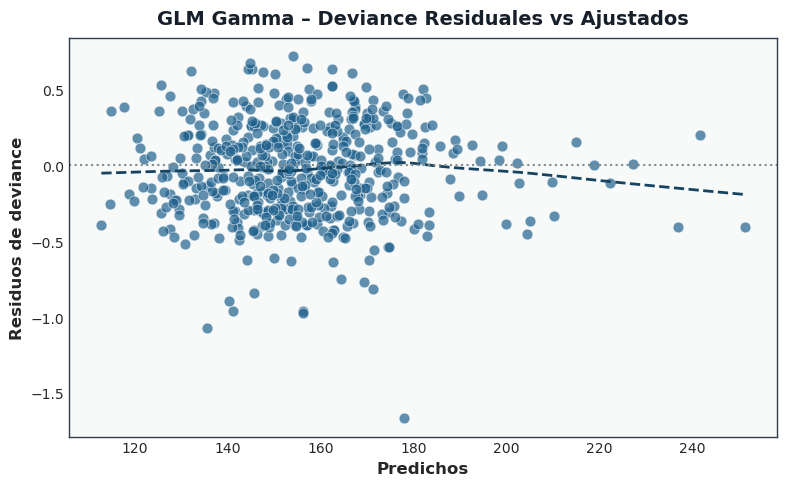

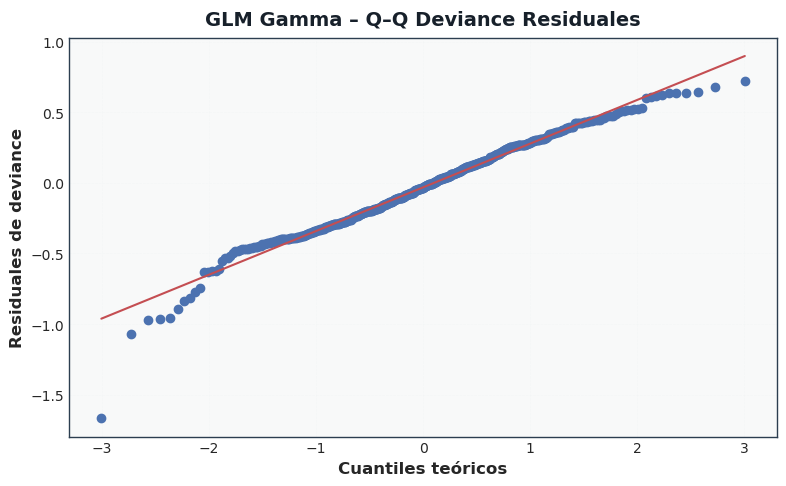

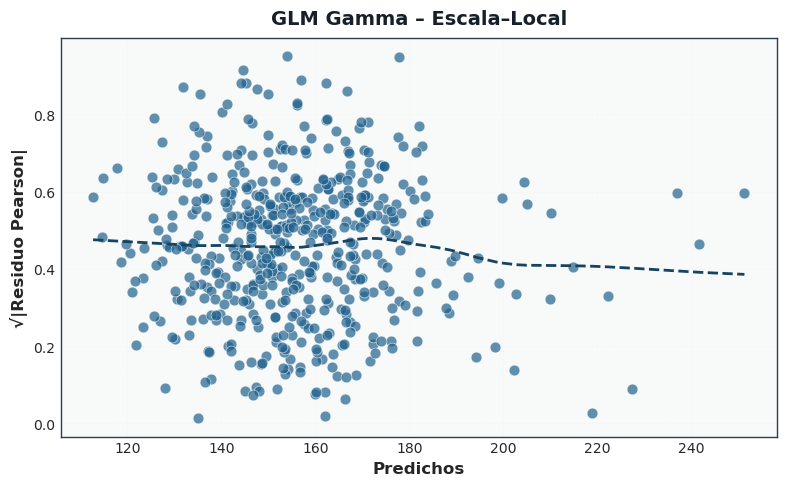

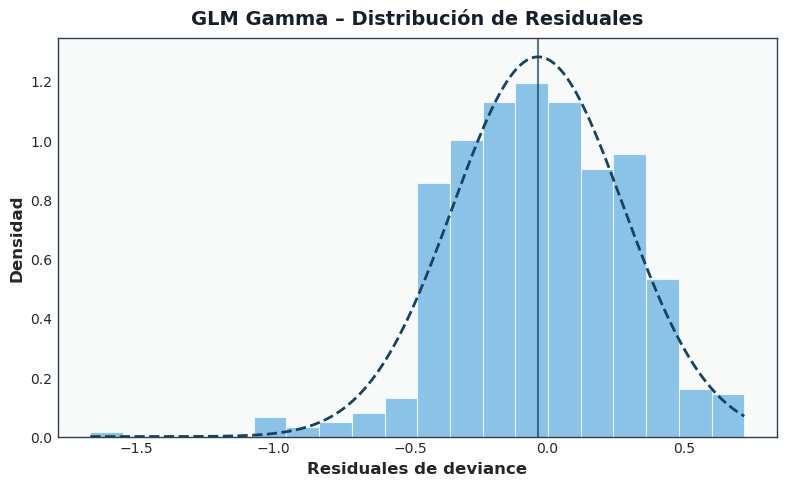

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# === (Reusa tu configuración de estilo "Wall Street") ===
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial','DejaVu Sans','Liberation Sans'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100,
    'figure.figsize': (8,5),
    'axes.facecolor': 'white',
    'grid.color': '#ECF0F1',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5
})

col = {
    'puntos': '#1F618D',
    'puntos_alpha': 0.7,
    'lowess': '#154360',
    'hist': '#5DADE2',
    'linea_cero': '#7F8C8D',
    'titulo': '#17202A',
    'borde': '#2C3E50',
    'fondo_panel': '#F8F9F9'
}

def estilo_comun(ax, titulo):
    ax.set_facecolor(col['fondo_panel'])
    for spine in ax.spines.values():
        spine.set_color(col['borde'])
        spine.set_linewidth(1.0)
    ax.tick_params(direction='in', length=5)
    ax.grid(True, alpha=0.3)
    ax.set_title(titulo, fontweight='bold', color=col['titulo'], pad=10)

# === Paso 1: Cargar datos y definir y, X ===
df = pd.read_csv("/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/best_of_five.csv")
y = df['minutes']
X = df.drop(columns=['minutes'])
X_const = sm.add_constant(X)

# === Paso 2: Ajustar GLM Gamma con link log ===
glm_gamma = sm.GLM(
    y,
    X_const,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

# === Paso 3: Mostrar resumen ===
print(glm_gamma.summary())

# === Paso 4: Calcular residuos ===
fitted     = glm_gamma.fittedvalues
resid_dev  = glm_gamma.resid_deviance
resid_pear = glm_gamma.resid_pearson

# === Paso 5: Gráficos diagnósticos ===

# 5.1 Residuos de deviance vs ajustados
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.scatter(fitted, resid_dev,
           alpha=col['puntos_alpha'],
           color=col['puntos'], s=60,
           edgecolor='white', linewidth=0.5)
low = sm.nonparametric.lowess(resid_dev, fitted)
ax.plot(low[:,0], low[:,1], '--', color=col['lowess'], linewidth=2)
# Línea horizontal corregida:
ax.axhline(0, color=col['linea_cero'], linestyle=':', linewidth=1.5)
ax.set_xlabel("Predichos", fontweight='bold')
ax.set_ylabel("Residuos de deviance", fontweight='bold')
estilo_comun(ax, "GLM Gamma – Deviance Residuales vs Ajustados")
plt.tight_layout()
plt.show()

# 5.2 Q–Q plot de residuos de deviance
plt.figure(figsize=(8,5))
ax = plt.gca()
stats.probplot(resid_dev, dist="norm", plot=ax)
ax.set_xlabel("Cuantiles teóricos", fontweight='bold')
ax.set_ylabel("Residuales de deviance", fontweight='bold')
estilo_comun(ax, "GLM Gamma – Q–Q Deviance Residuales")
plt.tight_layout()
plt.show()

# 5.3 Escala–Local de residuos Pearson
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.scatter(fitted, np.sqrt(np.abs(resid_pear)),
           alpha=col['puntos_alpha'],
           color=col['puntos'], s=60,
           edgecolor='white', linewidth=0.5)
low2 = sm.nonparametric.lowess(np.sqrt(np.abs(resid_pear)), fitted)
ax.plot(low2[:,0], low2[:,1], '--', color=col['lowess'], linewidth=2)
ax.set_xlabel("Predichos", fontweight='bold')
ax.set_ylabel("√|Residuo Pearson|", fontweight='bold')
estilo_comun(ax, "GLM Gamma – Escala–Local")
plt.tight_layout()
plt.show()

# 5.4 Histograma de residuos de deviance
plt.figure(figsize=(8,5))
ax = plt.gca()
n, bins, _ = ax.hist(resid_dev,
                     bins=20,
                     density=True,
                     alpha=0.7,
                     color=col['hist'],
                     edgecolor='white',
                     linewidth=0.8)
x = np.linspace(bins.min(), bins.max(), 200)
ax.plot(x,
        stats.norm.pdf(x,
                       loc=resid_dev.mean(),
                       scale=resid_dev.std()),
        '--', color=col['lowess'], linewidth=2)
ax.axvline(resid_dev.mean(),
           color=col['lowess'],
           linestyle='-',
           linewidth=1.5,
           alpha=0.7)
ax.set_xlabel("Residuales de deviance", fontweight='bold')
ax.set_ylabel("Densidad", fontweight='bold')
estilo_comun(ax, "GLM Gamma – Distribución de Residuales")
plt.tight_layout()
plt.show()


# Modelo Random forest y XG boost

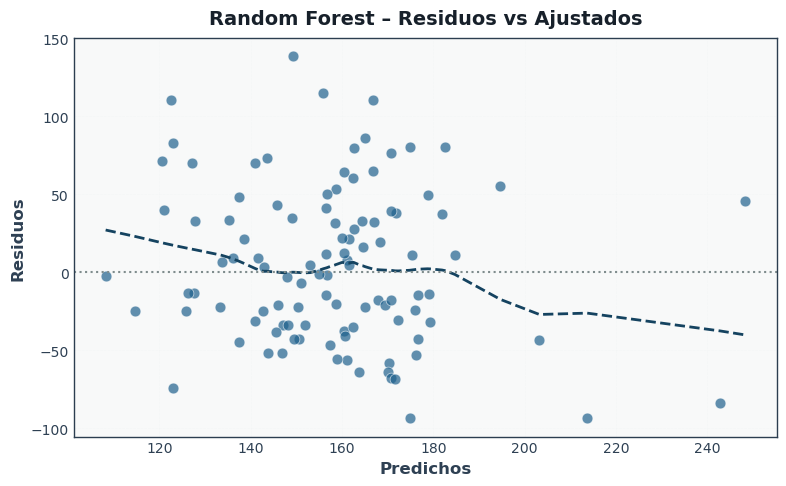

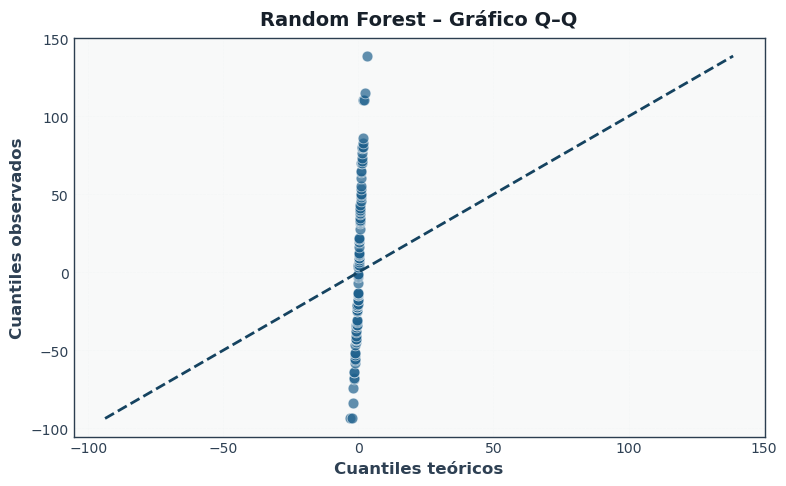

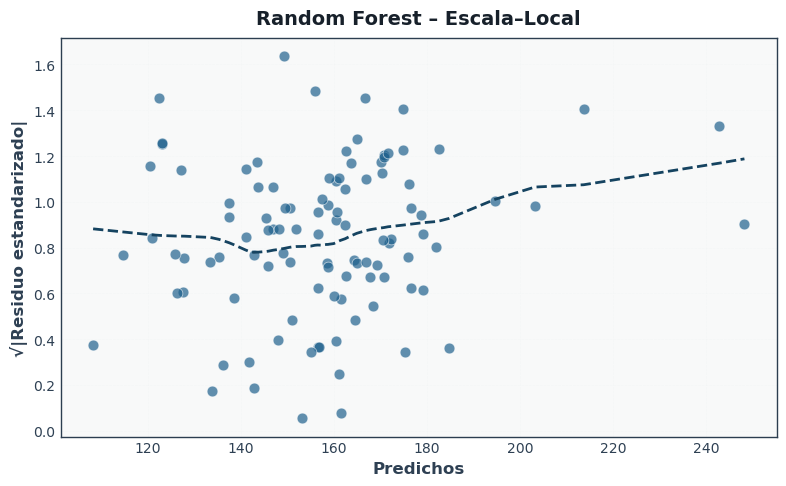

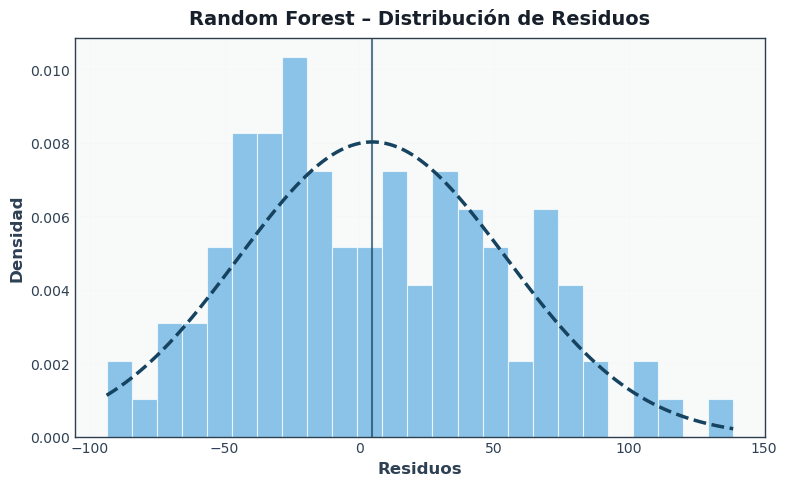

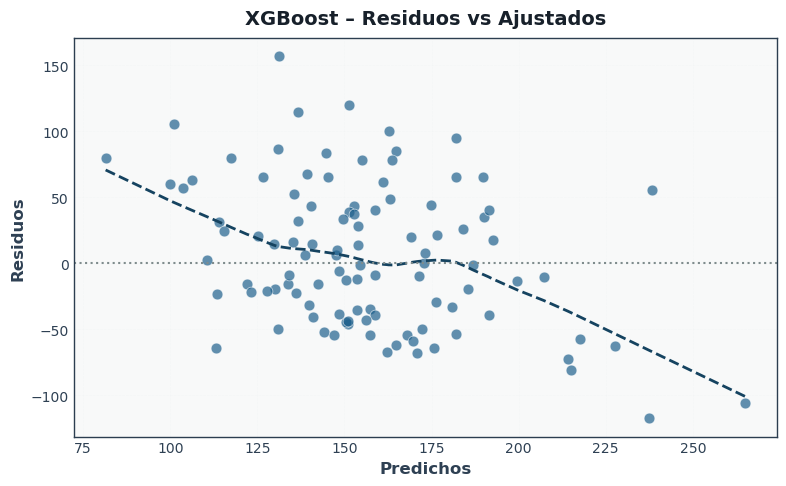

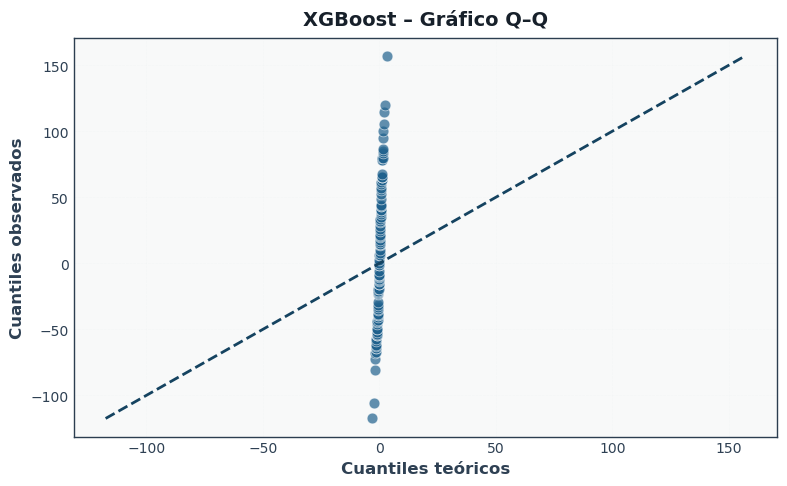

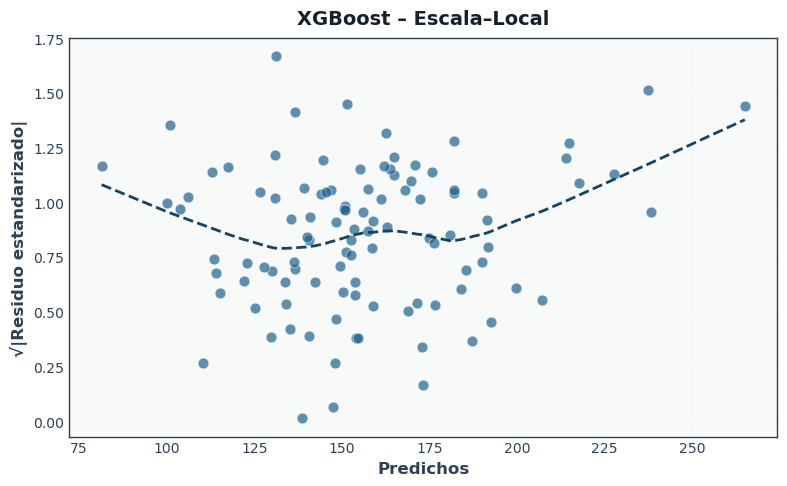

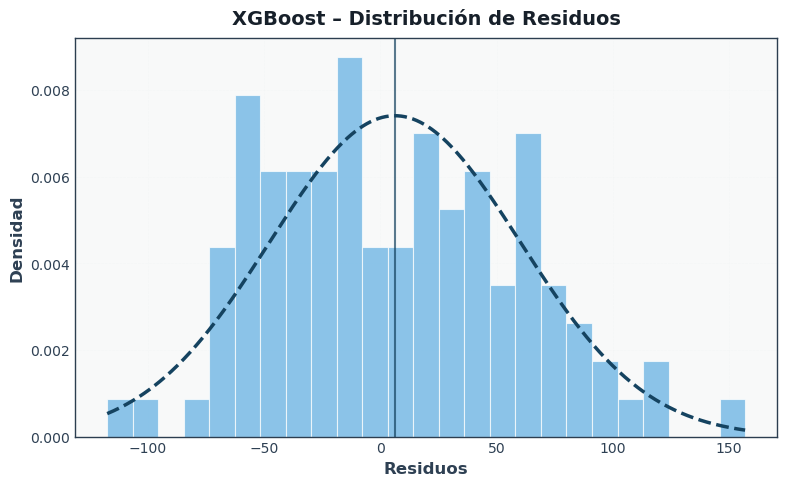

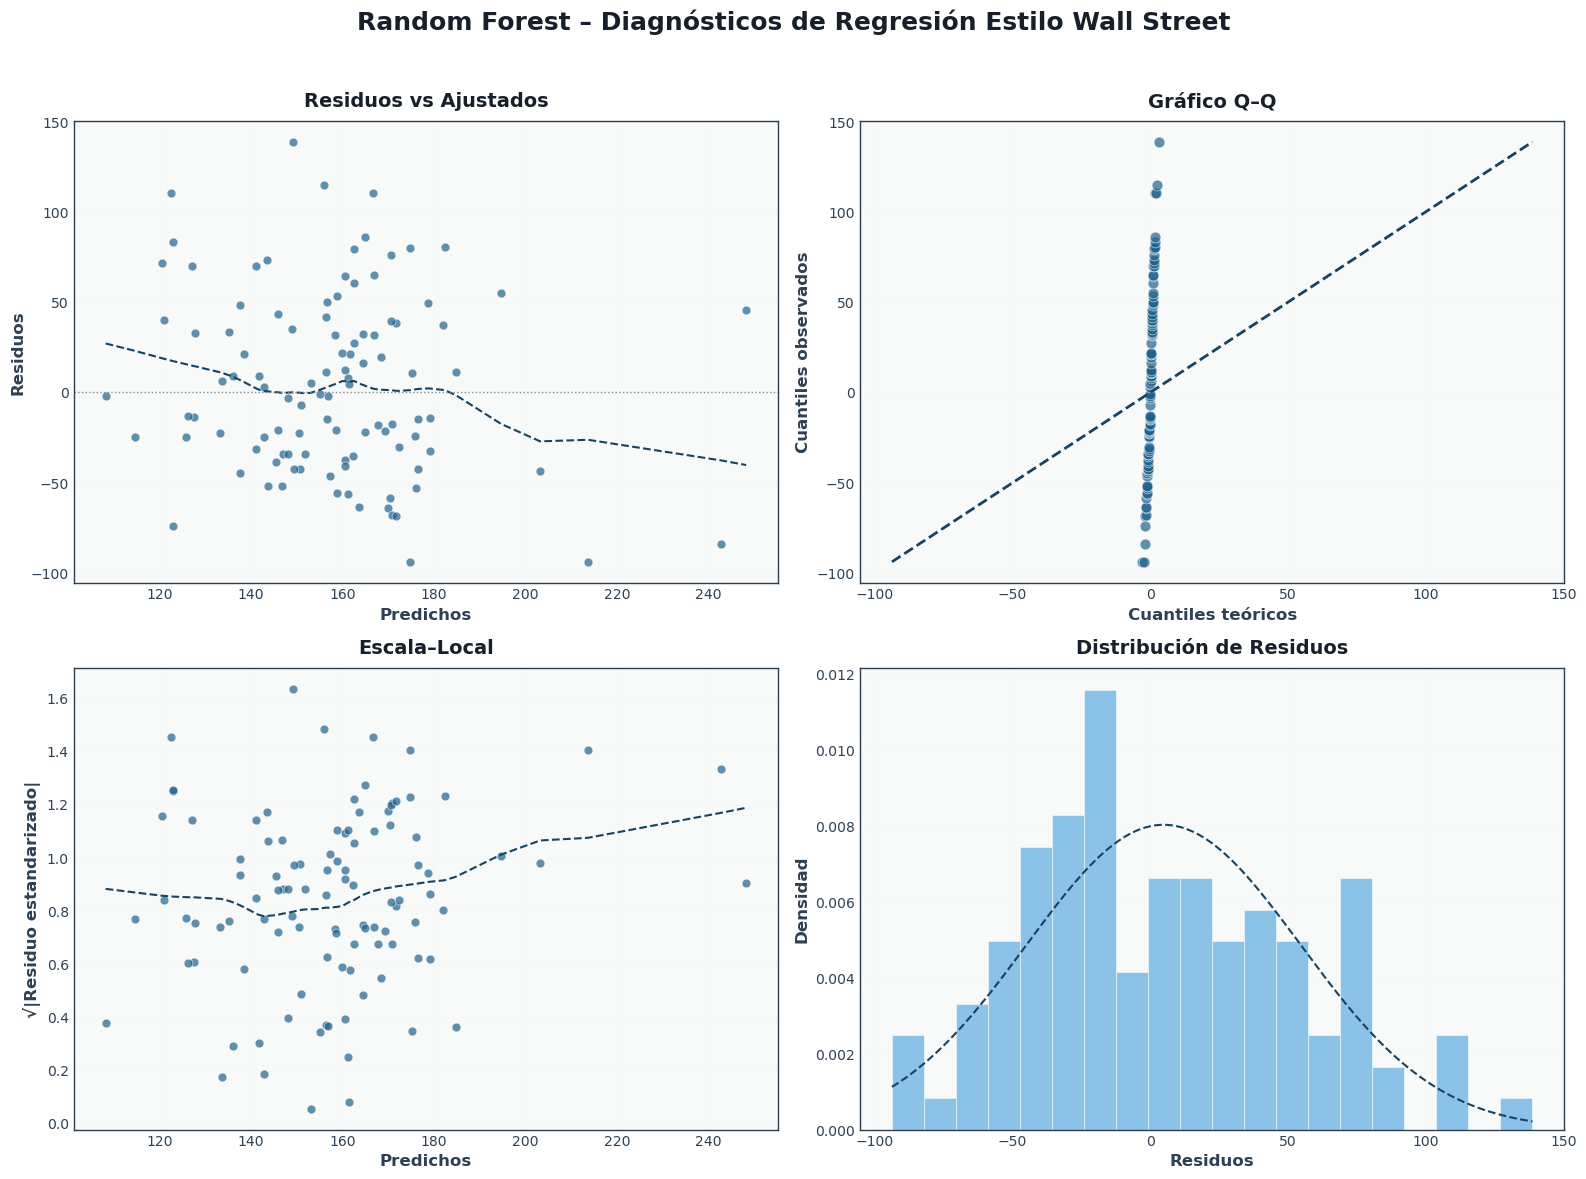

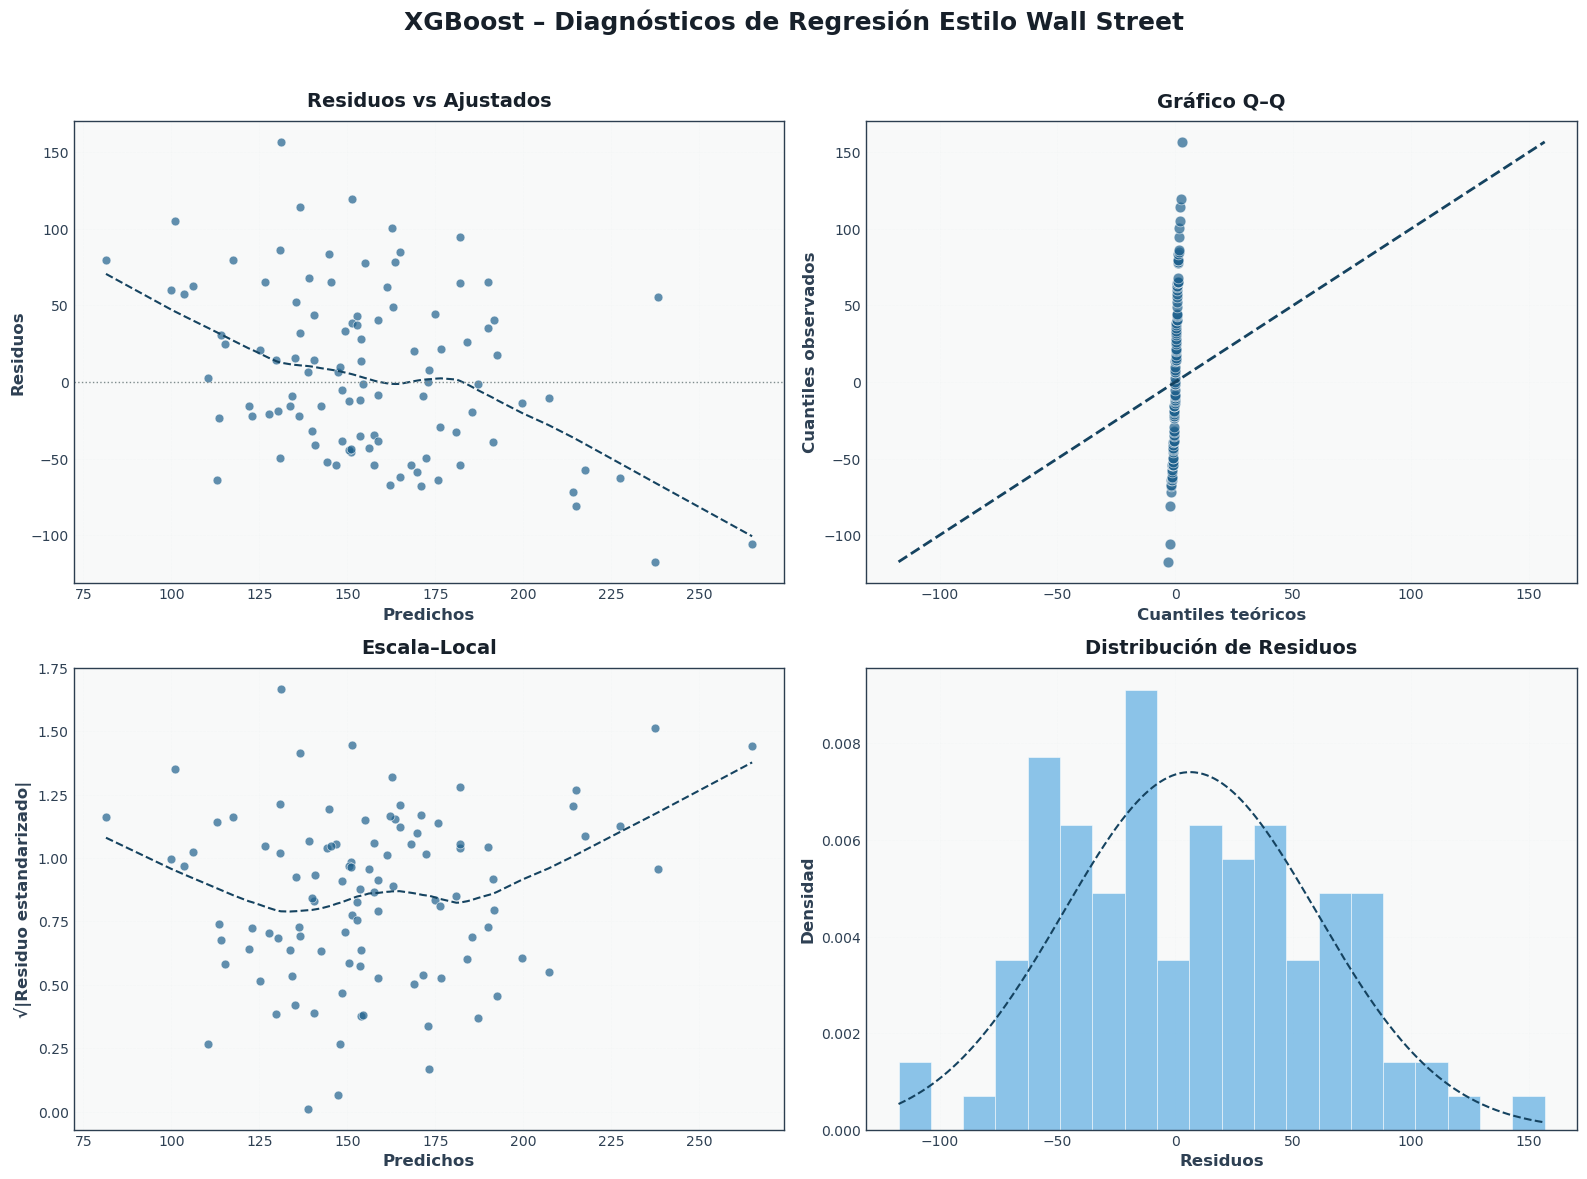

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec

# === Configuración de estilo "Wall Street" mejorado ===
plt.style.use('seaborn-v0_8-whitegrid')  # Base estilo seaborn como punto de partida

# Configuración de fuentes más profesionales - usando fuentes genéricas disponibles en todos los sistemas
plt.rcParams.update({
    'font.family': 'sans-serif',  # Cambiado de 'serif' a 'sans-serif' que está más disponible
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 100,
    'figure.figsize': (8, 5),
    'axes.facecolor': 'white',
    'axes.edgecolor': '#2E4053',
    'axes.labelcolor': '#2E4053',
    'axes.grid': True,
    'grid.color': '#ECF0F1',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'xtick.color': '#2E4053',
    'ytick.color': '#2E4053',
    'text.color': '#2E4053',
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Paleta de azules para estilo financiero/Wall Street
col = {
    'puntos': '#1F618D',       # Azul oscuro para puntos
    'puntos_alpha': 0.7,       # Transparencia
    'lowess': '#154360',       # Azul más oscuro para líneas de tendencia
    'hist': '#5DADE2',         # Azul medio para histogramas
    'stem': '#2471A3',         # Azul intenso para gráficos de tallo
    'linea_cero': '#7F8C8D',   # Gris para líneas de referencia
    'titulo': '#17202A',       # Casi negro para títulos
    'grid': '#ECF0F1',         # Gris muy claro para cuadrículas
    'borde': '#2C3E50',        # Azul oscuro para bordes
    'fondo_panel': '#F8F9F9'   # Gris muy claro para fondo de paneles
}

def estilo_comun(ax, titulo):
    ax.set_facecolor(col['fondo_panel'])
    for spine in ax.spines.values():
        spine.set_color(col['borde'])
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    ax.grid(True, alpha=0.3)
    ax.set_title(titulo, fontweight='bold', color=col['titulo'], pad=10)

def qqplot_custom(data, ax):
    q = np.linspace(0.001, 0.999, len(data))
    y = np.sort(data)
    x = stats.norm.ppf(q)
    ax.scatter(x, y, alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
    mn, mx = min(x.min(), y.min()), max(x.max(), y.max())
    ax.plot([mn, mx], [mn, mx], linestyle='--', color=col['lowess'], lw=2)
    return ax

# === Paso 1: Preparar datos y dividir en train/test ===
df = pd.read_csv("/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/best_of_five.csv")
y = df['minutes']
X = df.drop(columns=['minutes'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Paso 2: Definir y entrenar modelos ===
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='rmse')
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    resid = y_test - preds
    # residuos estandarizados aproximados
    std_resid = (resid - resid.mean()) / resid.std()
    results[name] = {
        'fitted': preds,
        'resid': resid.values,
        'std_resid': std_resid.values
    }

# === Paso 3: Graficar diagnósticos por modelo ===
for name, res in results.items():
    fitted = res['fitted']
    resid = res['resid']
    std_resid = res['std_resid']

    # Residuals vs Fitted
    plt.figure(figsize=(8,5))
    ax = plt.gca()
    ax.scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
    low = sm.nonparametric.lowess(resid, fitted)
    ax.plot(low[:,0], low[:,1], linestyle='--', color=col['lowess'], lw=2)
    ax.axhline(0, linestyle=':', color=col['linea_cero'], lw=1.5)
    ax.set_xlabel("Predichos", fontweight='bold')
    ax.set_ylabel("Residuos", fontweight='bold')
    estilo_comun(ax, f"{name} – Residuos vs Ajustados")
    plt.tight_layout()
    plt.show()

    # Q–Q Plot
    plt.figure(figsize=(8,5))
    ax = plt.gca()
    qqplot_custom(resid, ax)
    ax.set_xlabel("Cuantiles teóricos", fontweight='bold')
    ax.set_ylabel("Cuantiles observados", fontweight='bold')
    estilo_comun(ax, f"{name} – Gráfico Q–Q")
    plt.tight_layout()
    plt.show()

    # Escala–Local
    plt.figure(figsize=(8,5))
    ax = plt.gca()
    ax.scatter(fitted, np.sqrt(np.abs(std_resid)), 
               alpha=col['puntos_alpha'], color=col['puntos'], s=60, edgecolor='white', lw=0.5)
    low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
    ax.plot(low2[:,0], low2[:,1], linestyle='--', color=col['lowess'], lw=2)
    ax.set_xlabel("Predichos", fontweight='bold')
    ax.set_ylabel("√|Residuo estandarizado|", fontweight='bold')
    estilo_comun(ax, f"{name} – Escala–Local")
    plt.tight_layout()
    plt.show()

    # Histograma de residuos
    plt.figure(figsize=(8,5))
    ax = plt.gca()
    n, bins, patches = ax.hist(resid, bins=25, density=True, alpha=0.7,
                               color=col['hist'], edgecolor='white', lw=0.8)
    x = np.linspace(bins.min(), bins.max(), 500)
    y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
    ax.plot(x, y, linestyle='--', color=col['lowess'], lw=2.5)
    ax.axvline(resid.mean(), linestyle='-', color=col['lowess'], lw=1.5, alpha=0.7)
    ax.set_xlabel("Residuos", fontweight='bold')
    ax.set_ylabel("Densidad", fontweight='bold')
    estilo_comun(ax, f"{name} – Distribución de Residuos")
    plt.tight_layout()
    plt.show()

# === Paso 4: Panel combinado (solo residuos vs ajustados, Q–Q, escala-local e histograma) ===
for name, res in results.items():
    fitted, resid, std_resid = res['fitted'], res['resid'], res['std_resid']

    fig = plt.figure(figsize=(16,12))
    gs = GridSpec(2,2, figure=fig)
    axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]),
           fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]

    # Resid vs Fitted
    axs[0].scatter(fitted, resid, alpha=col['puntos_alpha'], color=col['puntos'], s=40, edgecolor='white', lw=0.5)
    low = sm.nonparametric.lowess(resid, fitted)
    axs[0].plot(low[:,0], low[:,1], linestyle='--', color=col['lowess'], lw=1.5)
    axs[0].axhline(0, linestyle=':', color=col['linea_cero'], lw=1)
    axs[0].set_xlabel("Predichos", fontweight='bold'); axs[0].set_ylabel("Residuos", fontweight='bold')
    estilo_comun(axs[0], "Residuos vs Ajustados")

    # Q–Q
    qqplot_custom(resid, axs[1])
    axs[1].set_xlabel("Cuantiles teóricos", fontweight='bold'); axs[1].set_ylabel("Cuantiles observados", fontweight='bold')
    estilo_comun(axs[1], "Gráfico Q–Q")

    # Escala–Local
    axs[2].scatter(fitted, np.sqrt(np.abs(std_resid)),
                   alpha=col['puntos_alpha'], color=col['puntos'], s=40, edgecolor='white', lw=0.5)
    low2 = sm.nonparametric.lowess(np.sqrt(np.abs(std_resid)), fitted)
    axs[2].plot(low2[:,0], low2[:,1], linestyle='--', color=col['lowess'], lw=1.5)
    axs[2].set_xlabel("Predichos", fontweight='bold'); axs[2].set_ylabel("√|Residuo estandarizado|", fontweight='bold')
    estilo_comun(axs[2], "Escala–Local")

    # Histograma
    n, bins, patches = axs[3].hist(resid, bins=20, density=True, alpha=0.7,
                                   color=col['hist'], edgecolor='white', lw=0.5)
    x = np.linspace(bins.min(), bins.max(), 500)
    y = stats.norm.pdf(x, loc=resid.mean(), scale=resid.std())
    axs[3].plot(x, y, linestyle='--', color=col['lowess'], lw=1.5)
    axs[3].set_xlabel("Residuos", fontweight='bold'); axs[3].set_ylabel("Densidad", fontweight='bold')
    estilo_comun(axs[3], "Distribución de Residuos")

    fig.suptitle(f"{name} – Diagnósticos de Regresión Estilo Wall Street", 
                 fontsize=18, fontweight='bold', color=col['titulo'], y=0.98)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()


# Ver que distribcion se pega mas a los datos de minutos

El test de Kolmogorov–Smirnov (K–S) es una **prueba de bondad de ajuste no paramétrica** cuyo objetivo es comparar la **función de distribución empírica** de tus datos con la **función de distribución acumulada** (CDF) de una distribución teórica específica. Su fundamento se basa en:

1. **Hipótesis nula ($H_0$)**
   Los datos $x_1,\dots,x_n$ provienen de la distribución teórica en cuestión (por ejemplo, log-normal, gamma, normal, etc.).

2. **Estadístico $D$**

   $$
   D = \sup_x \bigl|\;F_n(x) - F_\theta(x)\bigr|
   $$

   donde

   * $F_n(x)$ es la CDF empírica calculada a partir de los datos,
   * $F_\theta(x)$ es la CDF de la distribución teórica con parámetros estimados por máxima verosimilitud,
   * $\sup_x$ indica el **valor máximo de la diferencia absoluta** en todo el rango de $x$.

3. **Interpretación de $D$**

   * Un **$D$ pequeño** significa que la CDF empírica está muy cerca de la CDF teórica en todos los puntos, lo que sugiere un buen ajuste.
   * Un **$D$ grande** indica discrepancias notables, implicando que los datos no se ajustan bien a esa distribución.

4. **Cálculo del p-valor**
   El p-valor asocia esa $D$ observada con su **distribución límite** bajo $H_0$.

   * Si **p-valor ≥ α**, no tenemos evidencia suficiente para rechazar $H_0$—la distribución teórica podría explicar los datos.
   * Si **p-valor < α**, rechazamos $H_0$ y concluimos que los datos no siguen esa distribución.

5. **Uso práctico**

   * Permite **comparar varias distribuciones candidatas** usando un mismo criterio ($D$).
   * Elegimos como “mejor ajuste” la que minimiza $D$, independientemente de que el p-valor formalmente rechace o no $H_0$ (en muestras grandes casi siempre saldrá p ≈ 0).


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Datos
data = pd.read_csv("/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/best_of_five.csv")

# Distribuciones candidatas
distribuciones = {
    'Normal':        stats.norm,
    'Log-normal':    stats.lognorm,
    'Gamma':         stats.gamma,
    'Exponencial':   stats.expon,
    'Weibull':       stats.weibull_min
}

# Evaluación con Kolmogorov–Smirnov
resultados = []
for nombre, dist in distribuciones.items():
    params = dist.fit(data)
    D, p_value = stats.kstest(data, dist.name, args=params)
    resultados.append({
        'Distribución': nombre,
        'D (K–S)':       D,
        'p-valor (K–S)': p_value
    })

# Mostrar resultados ordenados
df_results = pd.DataFrame(resultados).sort_values('D (K–S)')
print(df_results.to_markdown(index=False))


| Distribución   |   D (K–S) |   p-valor (K–S) |
|:---------------|----------:|----------------:|
| Weibull        | 0.0431441 |     0.280688    |
| Gamma          | 0.044744  |     0.242535    |
| Log-normal     | 0.0451432 |     0.233646    |
| Normal         | 0.0612196 |     0.0391817   |
| Exponencial    | 0.359023  |     2.10256e-60 |
